#IMPORTING THE LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

#Load and preprocess the dataset

In [2]:
(X_train, y_train), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

2


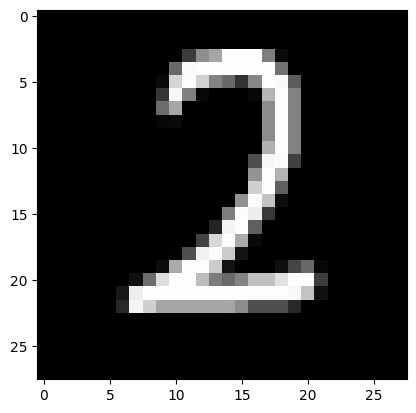

In [5]:
i = np.random.randint(0,60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray')

In [6]:
X_train= X_train.reshape(X_train.shape[0],28,28,1).astype('float32')   #1 is the no of channels

In [7]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

In [9]:
X_train = (X_train -127.5) / 127.5

In [10]:
X_train[0].min(),X_train[0].max() #Normalizing the data working with DCGAN better to keep this value

(-1.0, 1.0)

In [11]:
buffer_size = 60000   #minibatch--- this means the 256 batches and 1 batch with 234 images are sent and then the
batch_size = 256      #weights will be updated same again happens to the next batch and the images are updated.
buffer_size /batch_size

234.375

In [12]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)
#we put shuffle so that the neural network doesnt learn the pattern

In [13]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
X_train


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#GENERATOR


In [15]:
#100 neurons in input layers and total of 12544 neurons
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256,use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())         #batch Normalization
  network.add(layers.LeakyReLU())    #Activation function

  network.add(layers.Reshape((7,7,256)))

  #7x7x128
  network.add(layers.Conv2DTranspose(filters = 128,kernel_size = (5,5), padding = 'same', use_bias = False)) #all pixels are used
  network.add(layers.BatchNormalization())         #batch Normalization
  network.add(layers.LeakyReLU())    #Activation function

  #14x14x64
  network.add(layers.Conv2DTranspose(filters = 64,kernel_size = (5,5), padding = 'same',strides=(2,2), use_bias = False)) #all pixels are used
  network.add(layers.BatchNormalization())         #batch Normalization
  network.add(layers.LeakyReLU())    #Activation function

  #28x28x1
  network.add(layers.Conv2DTranspose(filters = 1,kernel_size = (5,5), padding = 'same',strides=(2,2), use_bias = False, activation='tanh')) #all pixels are used
  network.summary()
  return network


In [16]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [17]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [18]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.5594171 ,  0.7277098 , -1.1063002 ,  0.2500917 , -0.7637426 ,
         0.18516551,  0.05082641, -0.8857231 ,  1.4873159 , -0.6888784 ,
        -0.600246  , -1.4000041 ,  2.1493673 , -0.35113826, -0.39938992,
         0.4548323 , -1.2701175 , -0.23182642,  0.45932966, -1.2537656 ,
         1.2648089 , -0.8864915 , -0.50754327,  0.38925567,  1.9349794 ,
        -0.3309351 , -0.63148665, -1.0373418 ,  0.25990057, -1.9939508 ,
        -0.9815555 , -2.6424694 ,  1.2752807 , -0.12079996, -0.6012738 ,
         0.7288655 ,  0.75266564,  2.9779756 , -2.770934  , -0.58134   ,
        -0.5152519 , -0.40383926,  0.7316941 ,  0.02403789,  0.02111258,
        -1.1121314 ,  1.0915197 , -1.053883  , -0.8378486 , -0.9514668 ,
        -0.3863062 ,  0.02469976, -1.3068542 ,  0.78934413,  1.3744055 ,
         1.2738663 , -0.41225722, -1.224471  , -0.24078637, -0.40864787,
         1.5391495 ,  1.2904166 , -0.09280088, -1.5856206 ,  2.3301446 ,
 

In [19]:
generated_image = generator(noise,training = False)

In [20]:
generated_image.shape

TensorShape([1, 28, 28, 1])

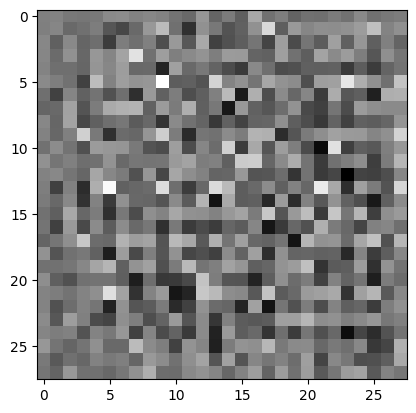

In [21]:
plt.imshow(generated_image[0,:,:,0],cmap = 'gray') # we only need the dimension -- so first 0 is the postion next is the dimension and channel

#DISCRIMINATOR


In [22]:
def build_discriminator():
  network = tf.keras.Sequential()

  #14x14x64
  network.add(layers.Conv2D(filters = 64,strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7x7x128
  network.add(layers.Conv2D(filters = 128,strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

In [23]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [24]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [25]:
discriminator(generated_image,training =False) #logits format

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00026736]], dtype=float32)>

In [26]:
tf.sigmoid(0.00060566)  #So you got 50 perecent as discriminator not trained yet,so it not sure, so as closer to 1 it is real,closer to 0 it is fake

<tf.Tensor: shape=(), dtype=float32, numpy=0.5001514>

#ERROR CALCULATION(LOSS FUNCTION)

In [27]:
#Here we connect the generator and the discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True) #used in binary classfication.

In [28]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [29]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [30]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

#TRAINING

In [32]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [33]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [34]:
batch_size,noise_dimension

(256, 100)

In [35]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  #print(noise.shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)#Here we send the real images
    fake_output = discriminator(generated_images, training = True)#Here we send the generated images and output the logits

    gen_loss = generator_loss(fake_output)#Compare with the vector of ones with the generated image
    disc_loss = discriminator_loss(expected_output, fake_output)#Here it return the total loss

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [36]:
tf.config.run_functions_eagerly(True)
X_train_batch = X_train.as_numpy_iterator().next()
train(X_train_batch)

In [37]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [38]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape) here it prints the 256 batches and each batch has 234 images in it
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)#As 16 images are there
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')# To denormalize when we intially normalized in the preporcess stage
      plt.axis('off')
    plt.show()

Epoch:  1


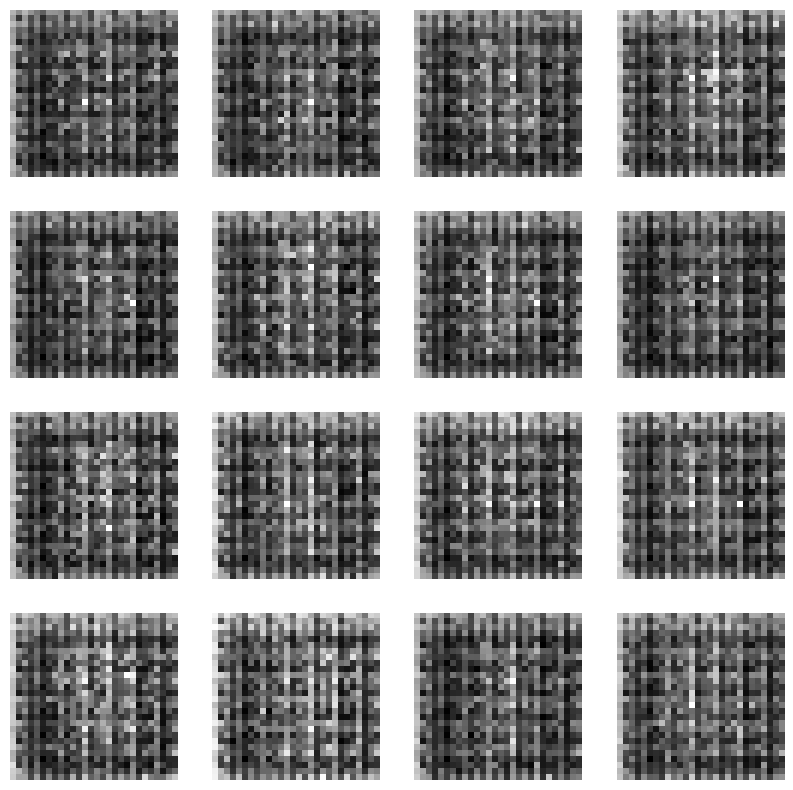

Epoch:  2


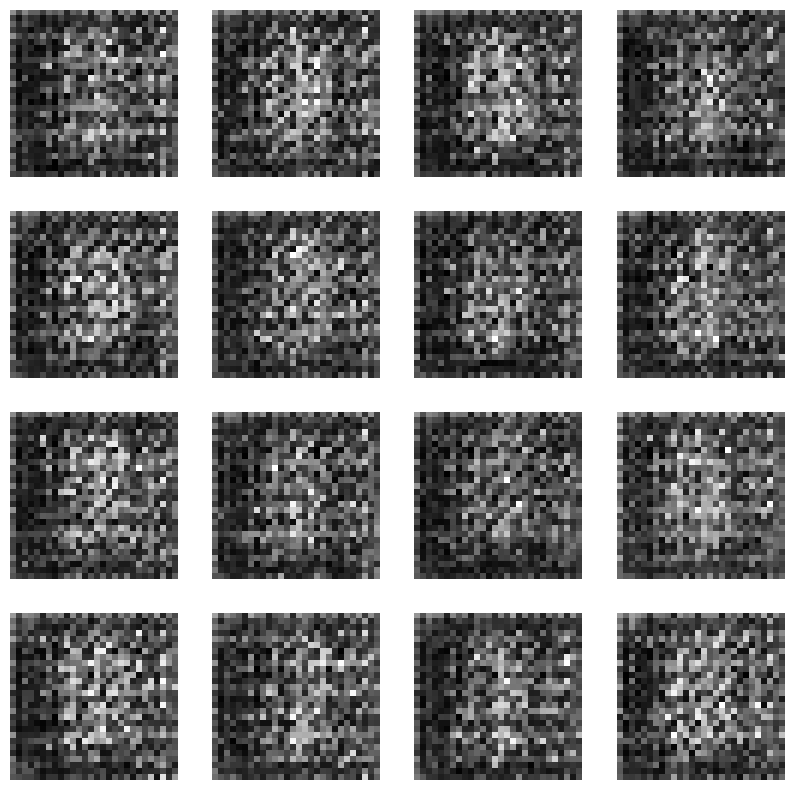

Epoch:  3


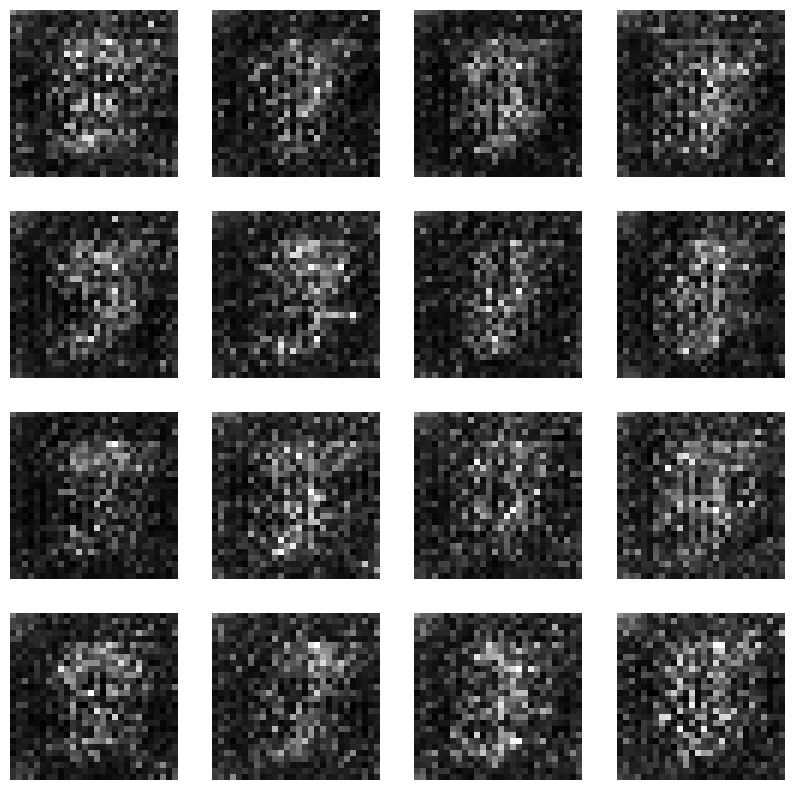

Epoch:  4


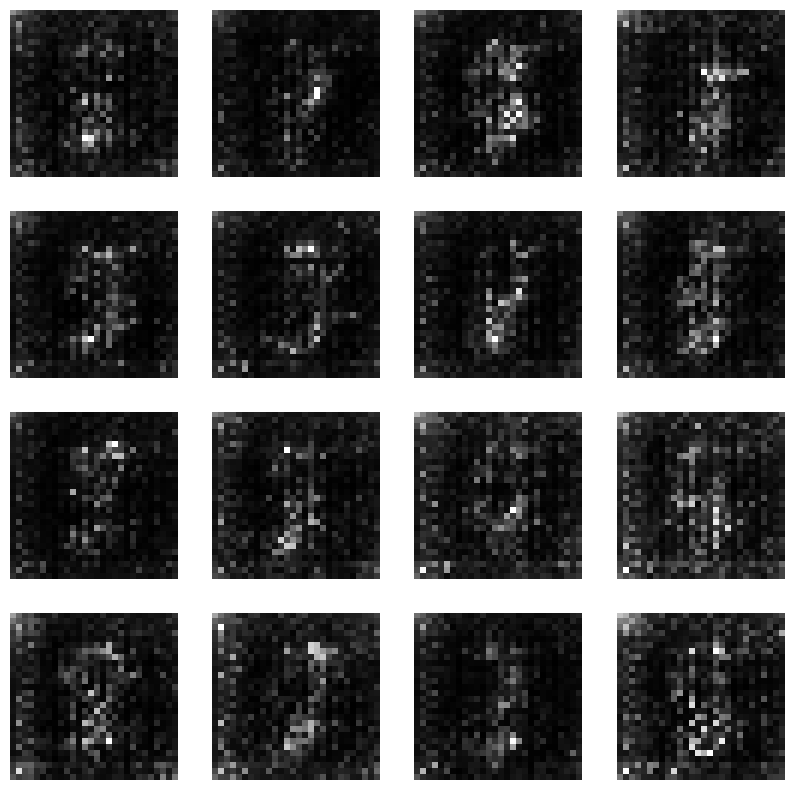

Epoch:  5


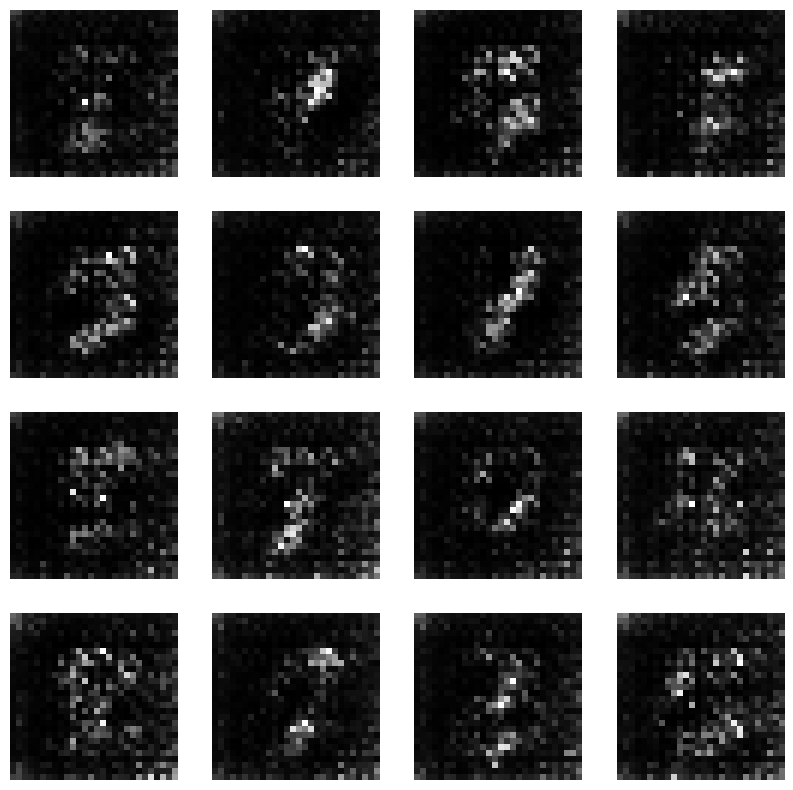

Epoch:  6


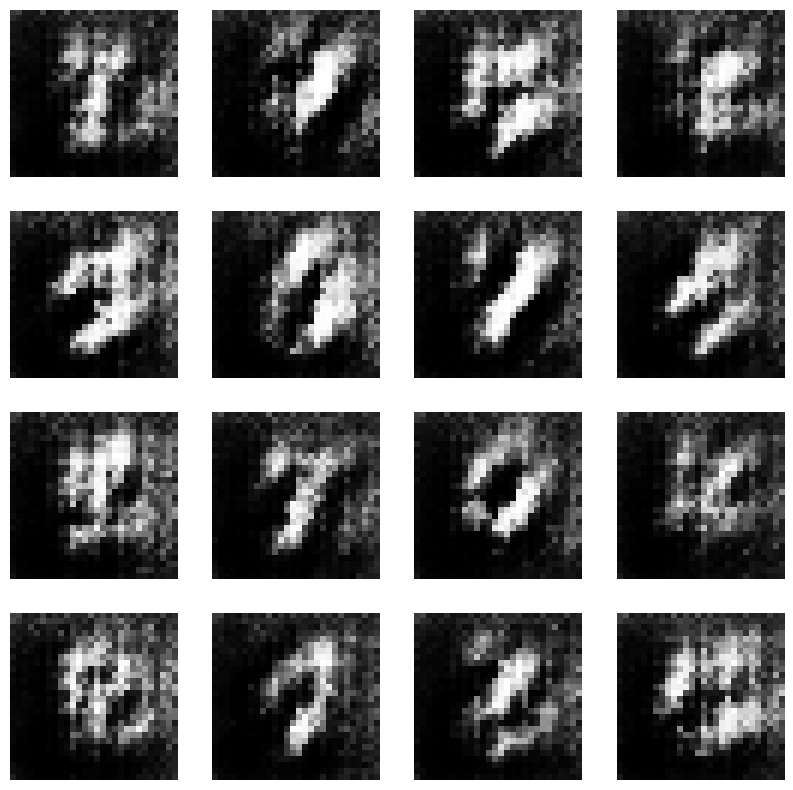

Epoch:  7


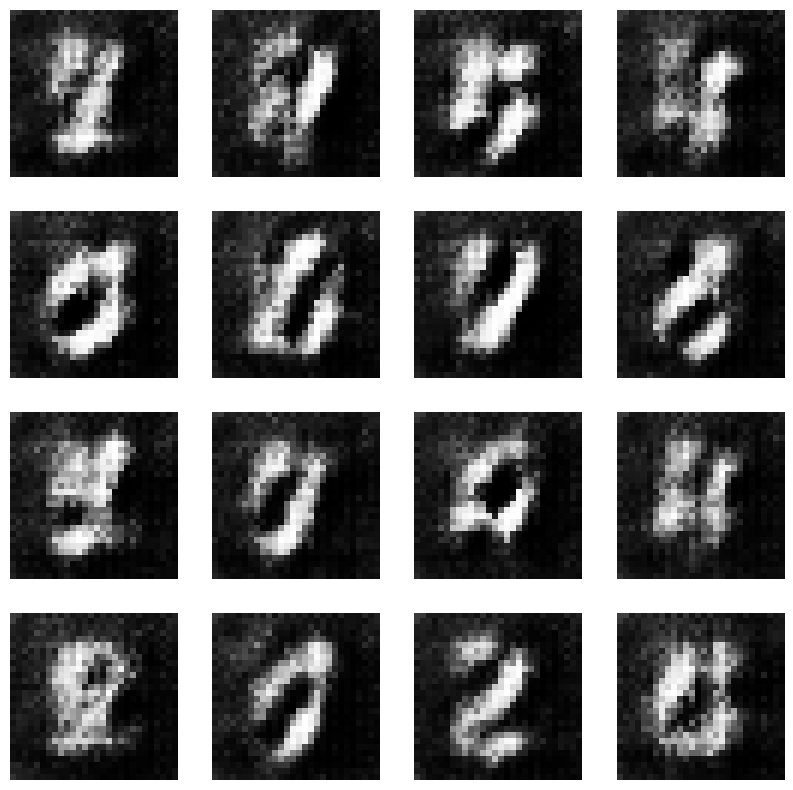

Epoch:  8


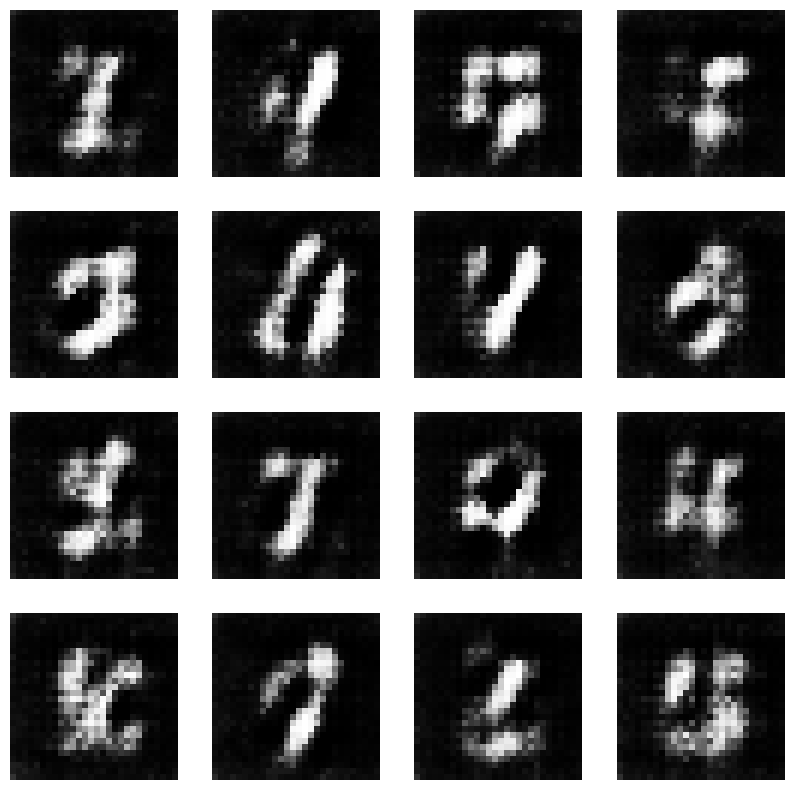

Epoch:  9


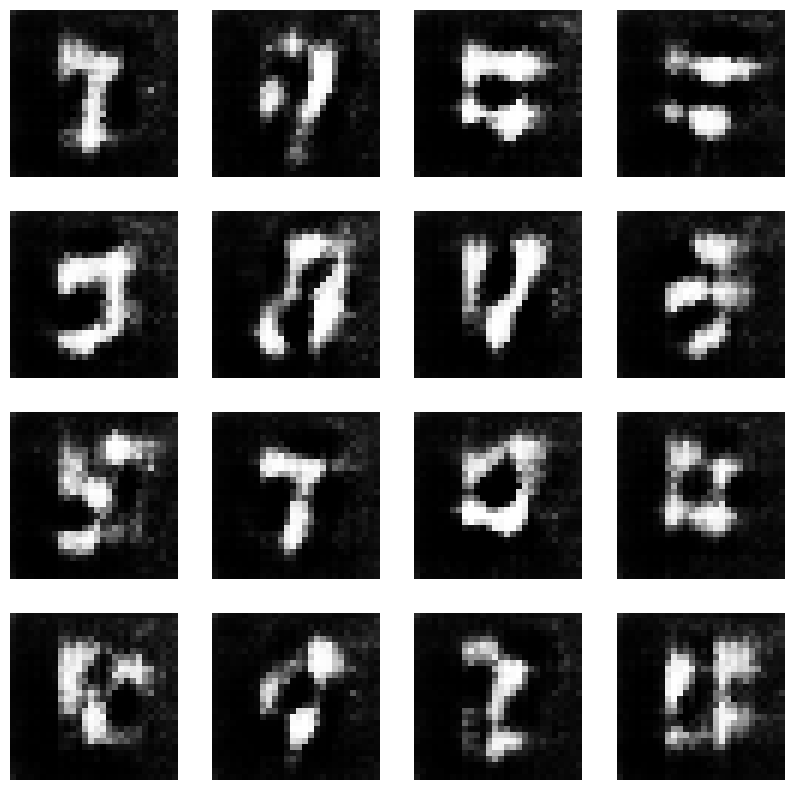

Epoch:  10


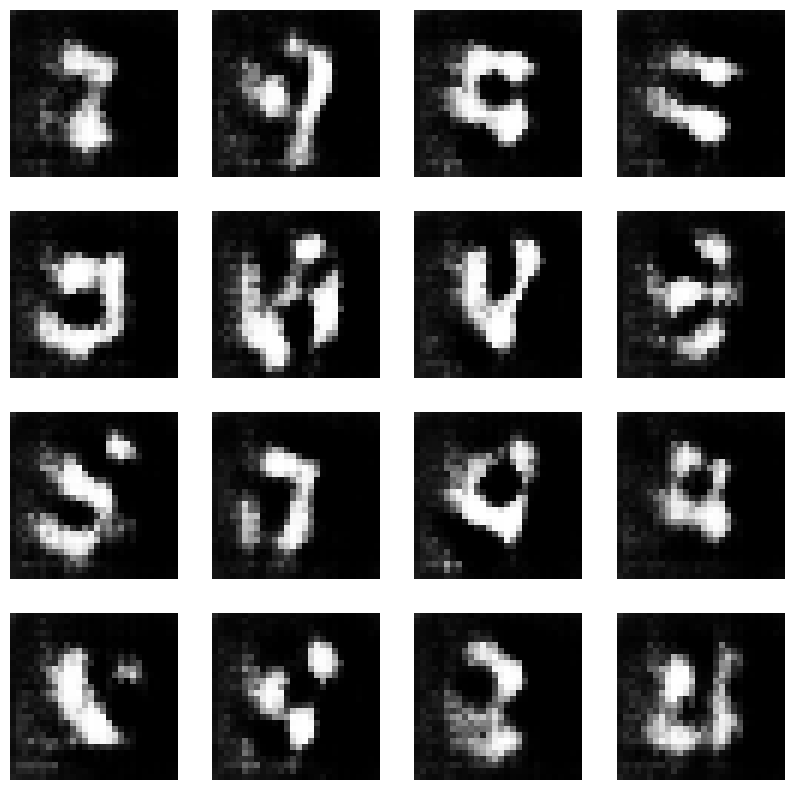

Epoch:  11


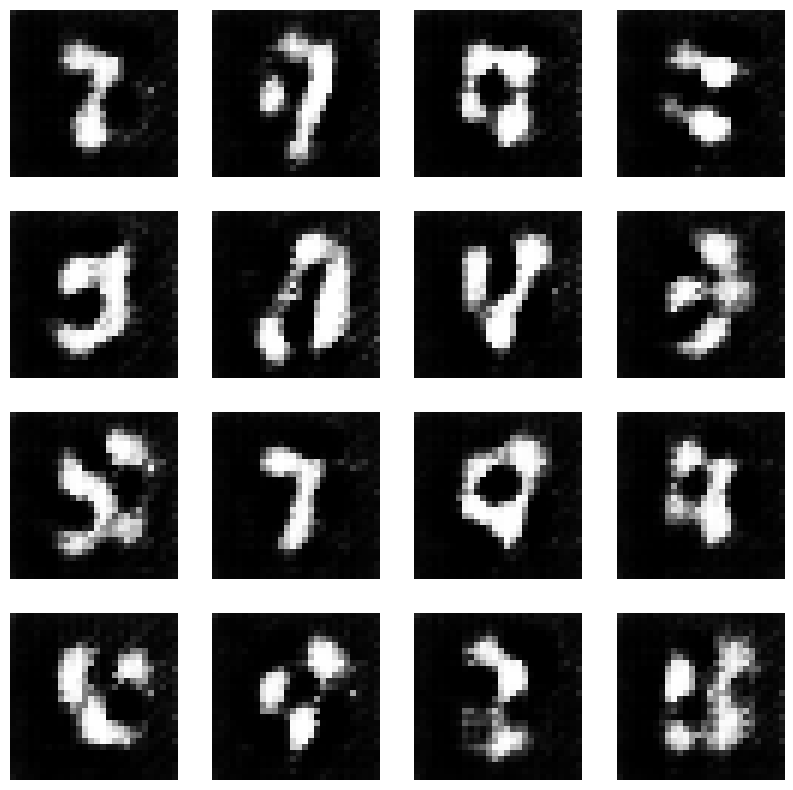

Epoch:  12


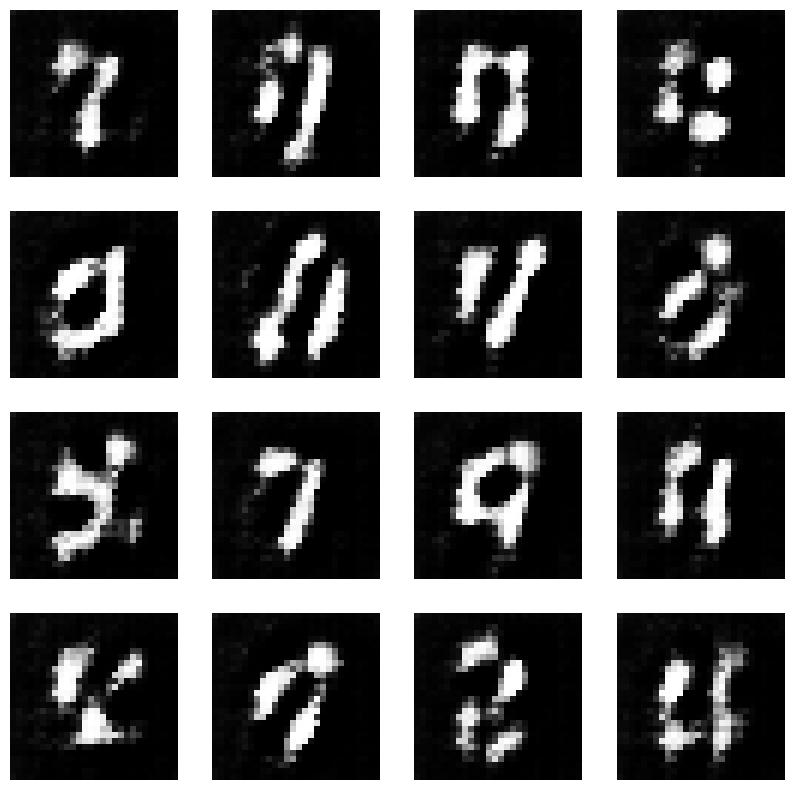

Epoch:  13


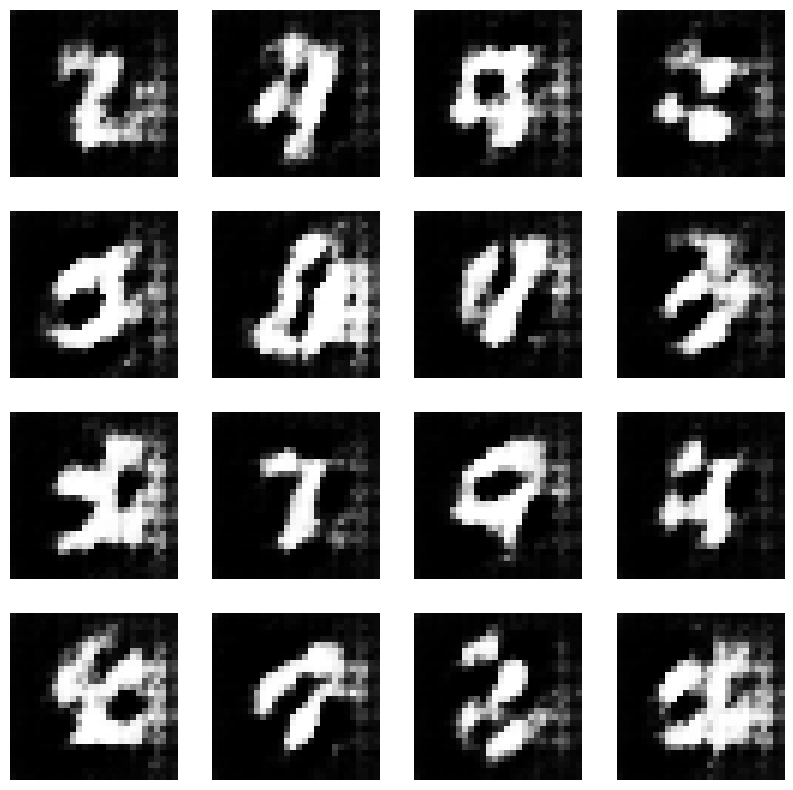

Epoch:  14


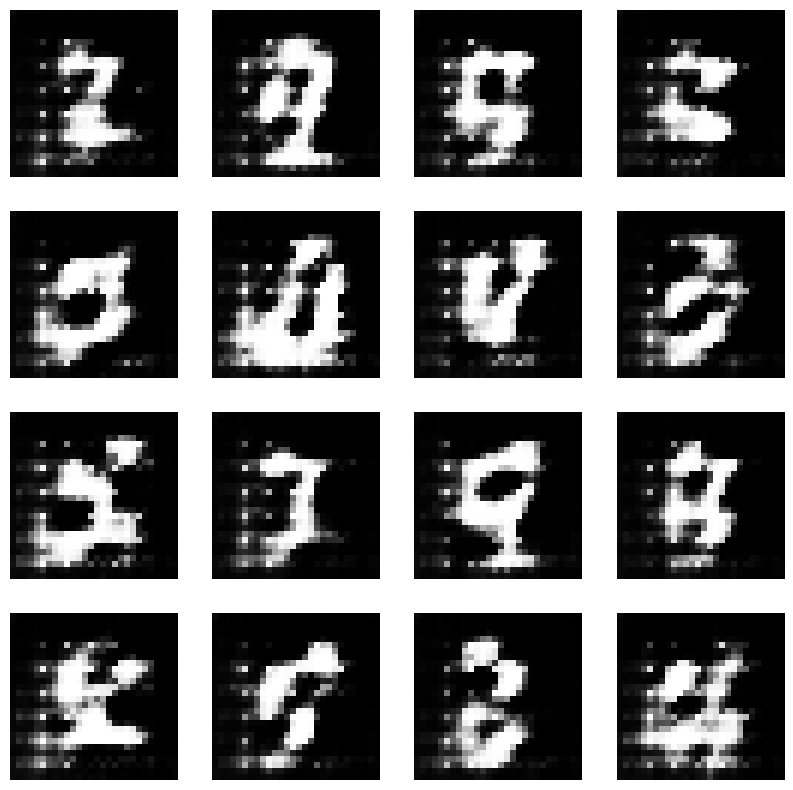

Epoch:  15


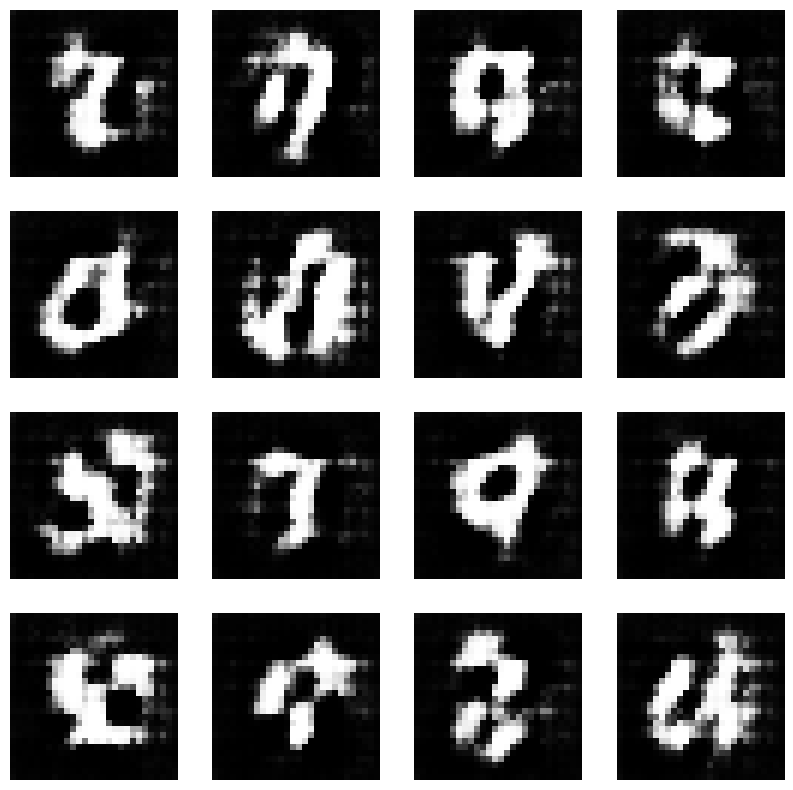

Epoch:  16


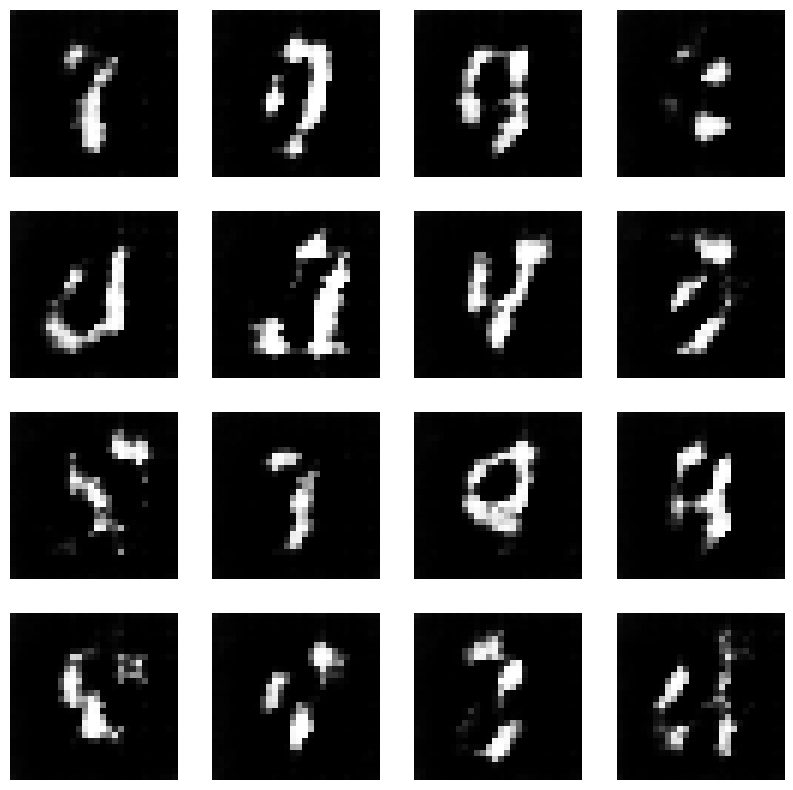

Epoch:  17


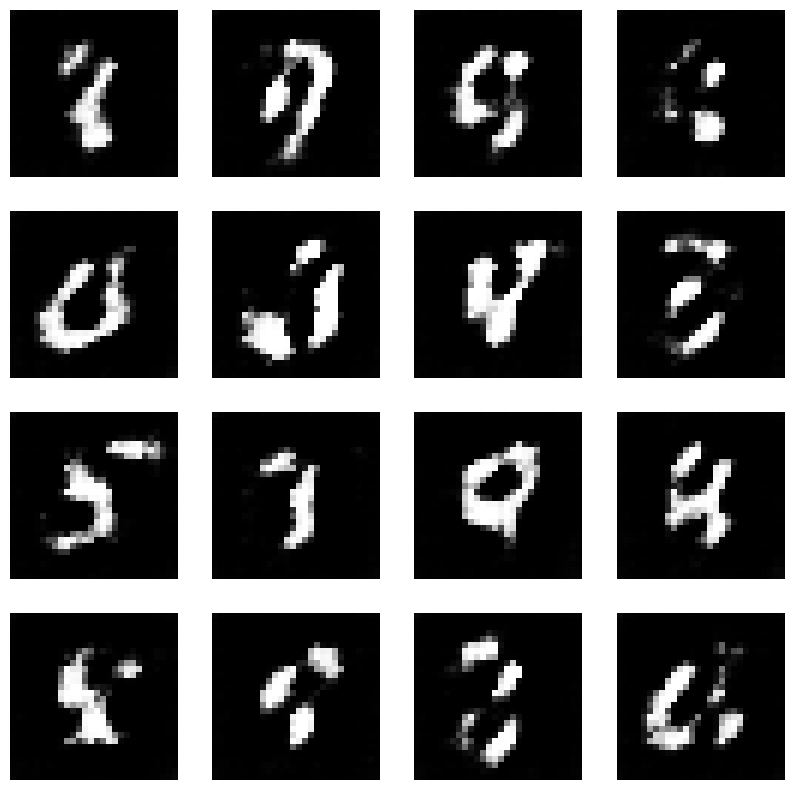

Epoch:  18


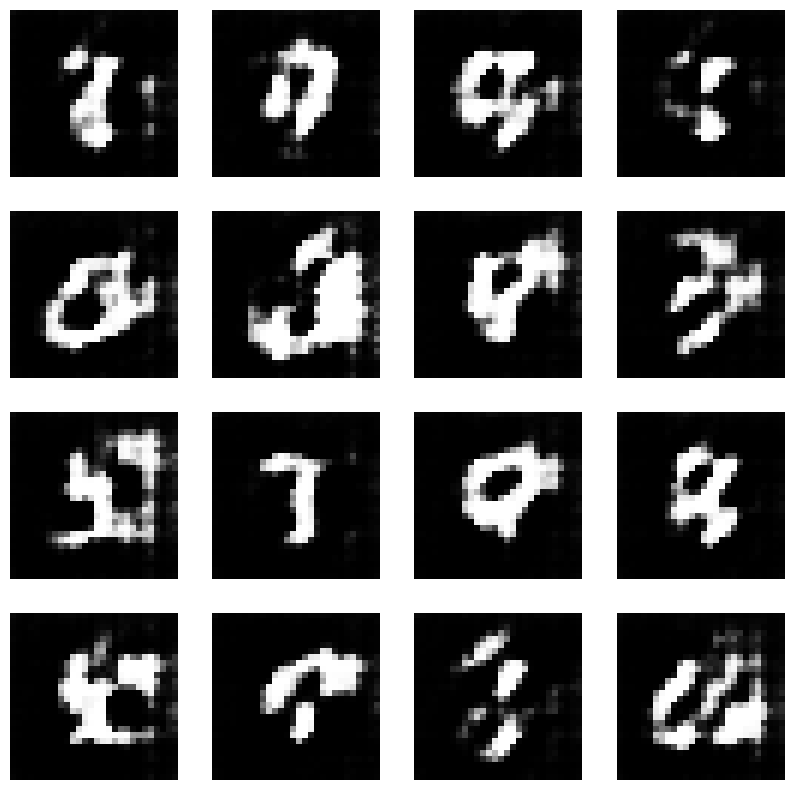

Epoch:  19


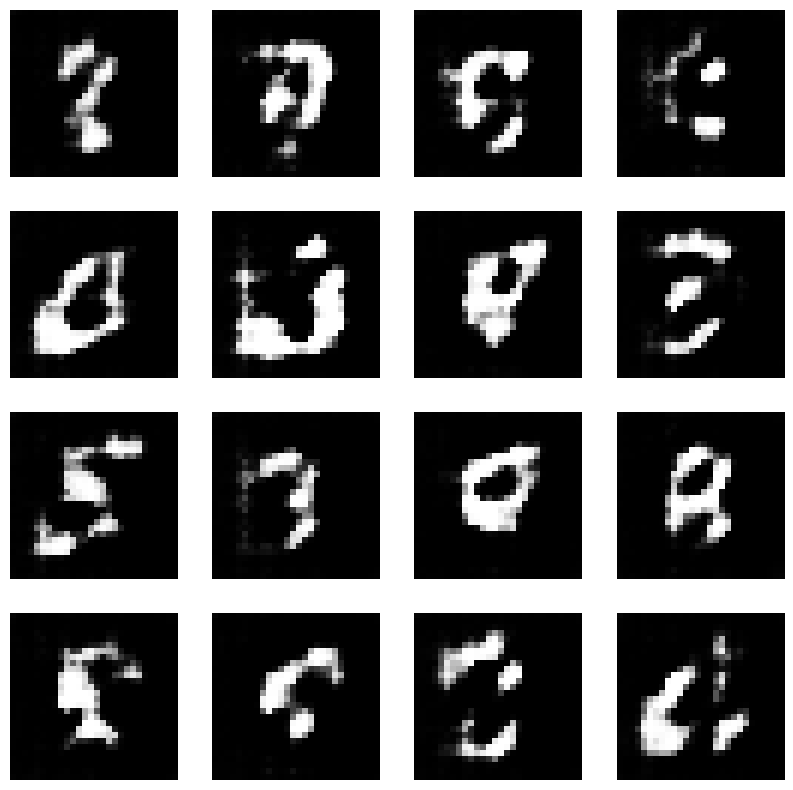

Epoch:  20


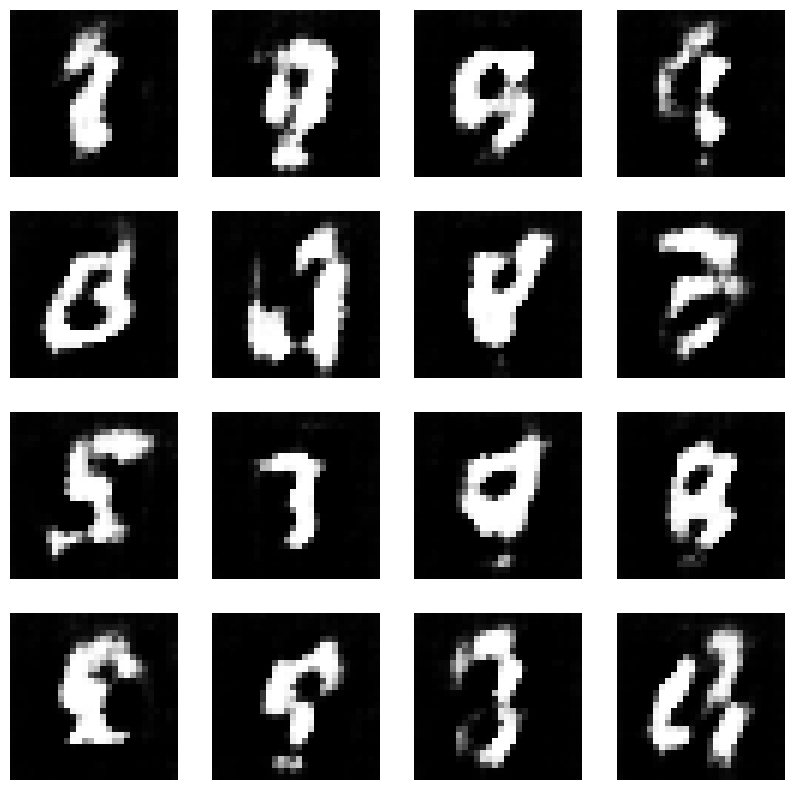

Epoch:  21


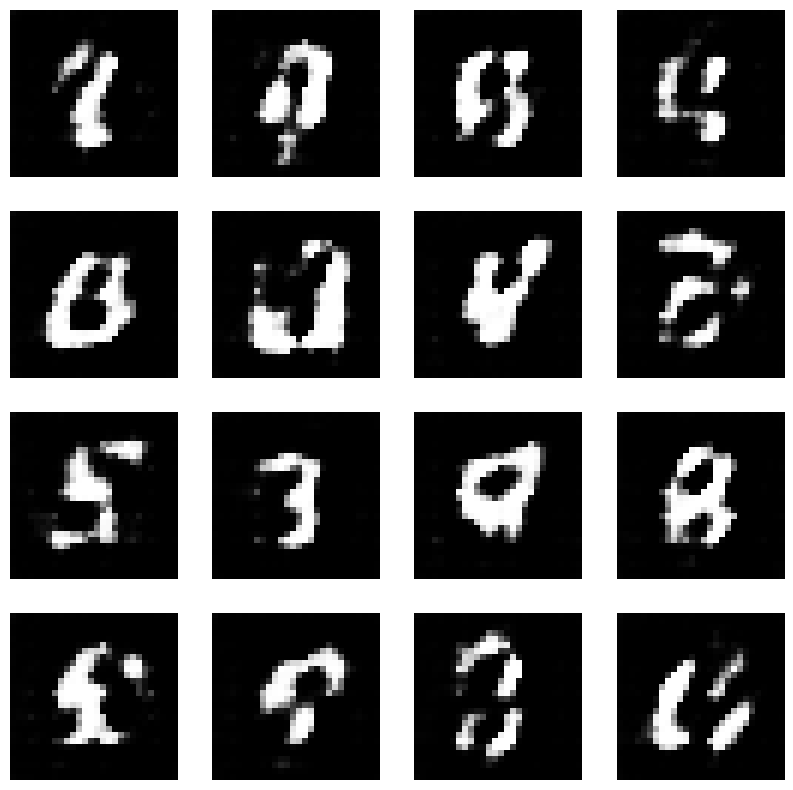

Epoch:  22


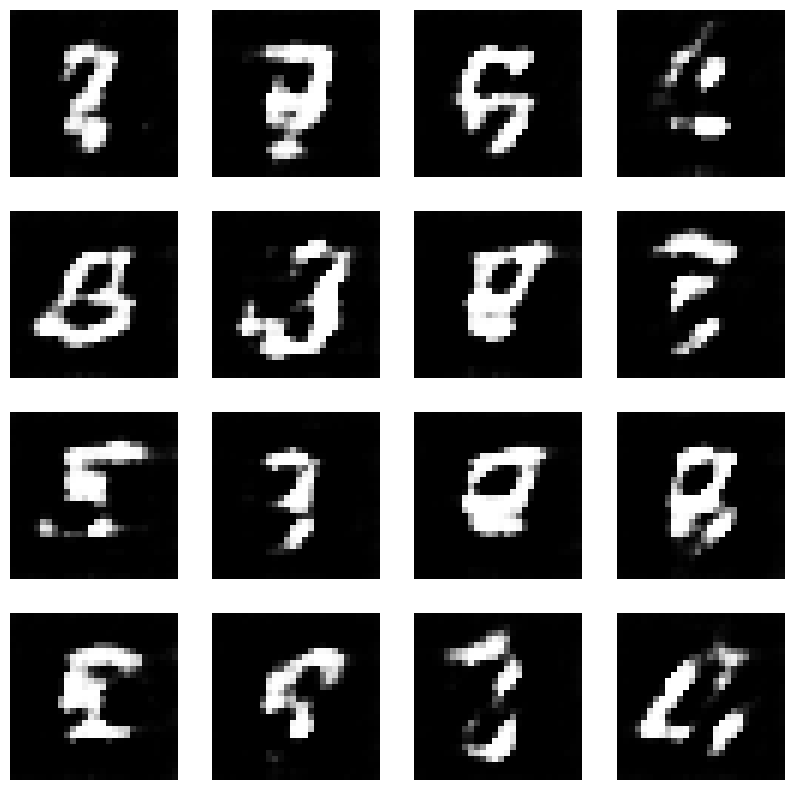

Epoch:  23


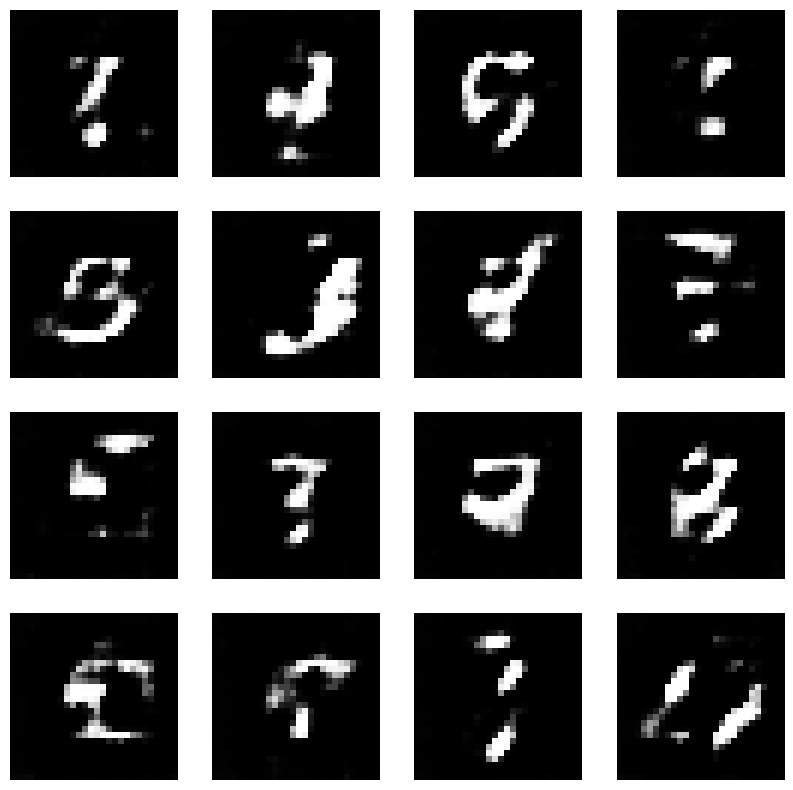

Epoch:  24


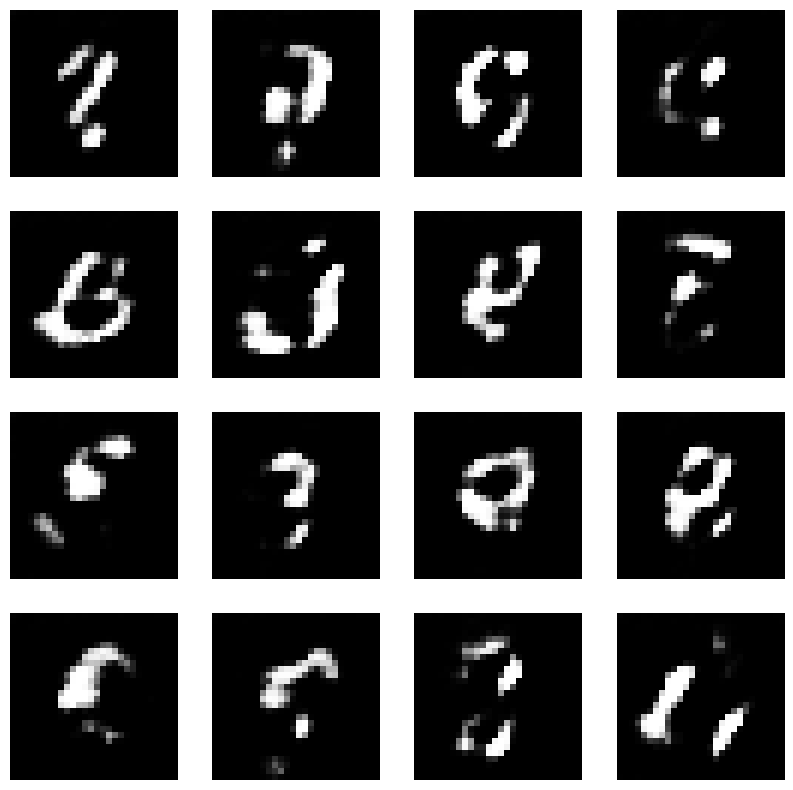

Epoch:  25


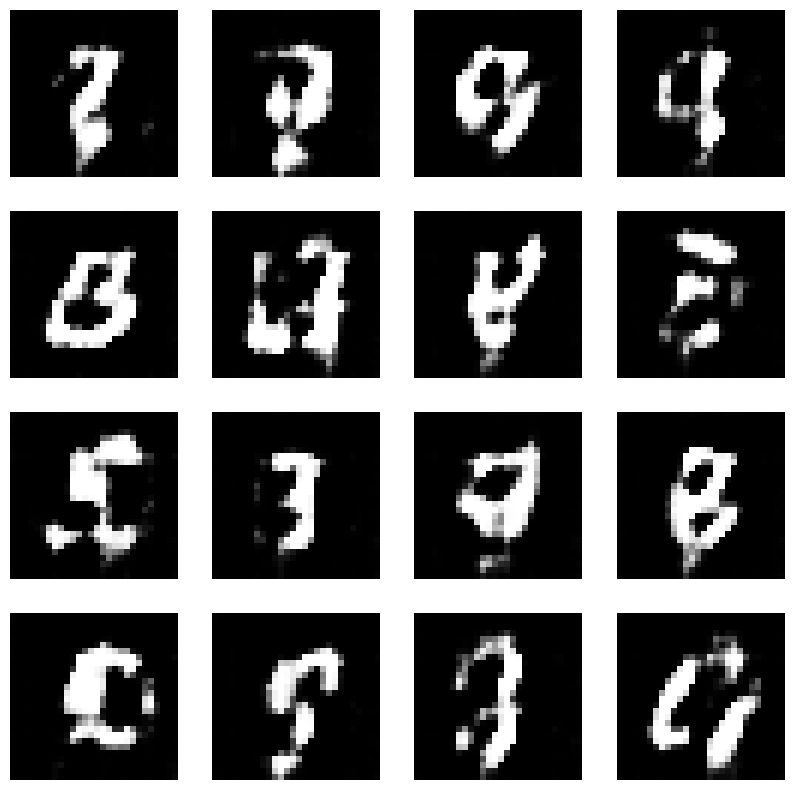

Epoch:  26


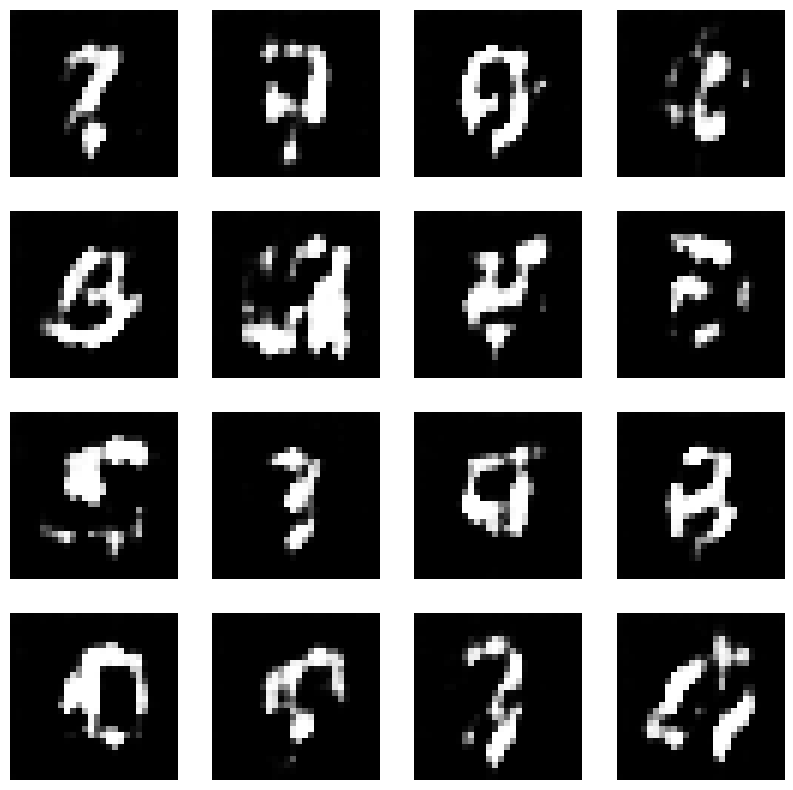

Epoch:  27


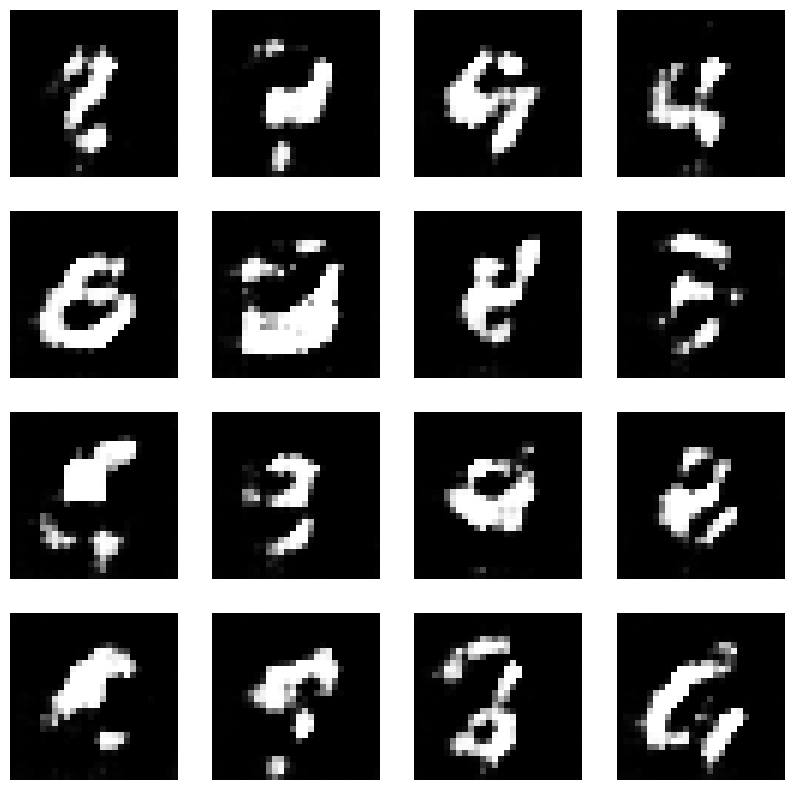

Epoch:  28


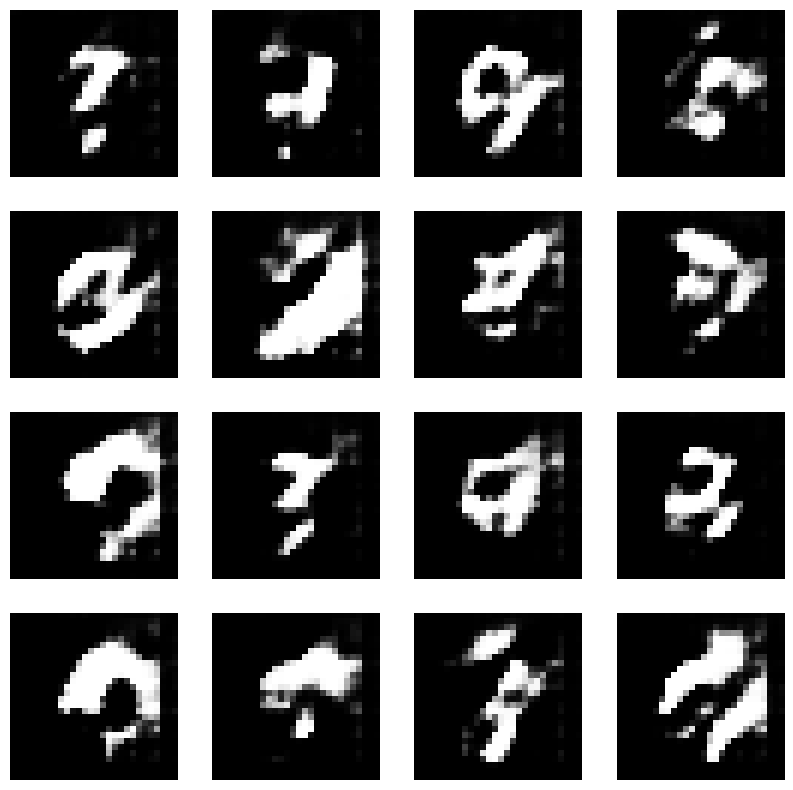

Epoch:  29


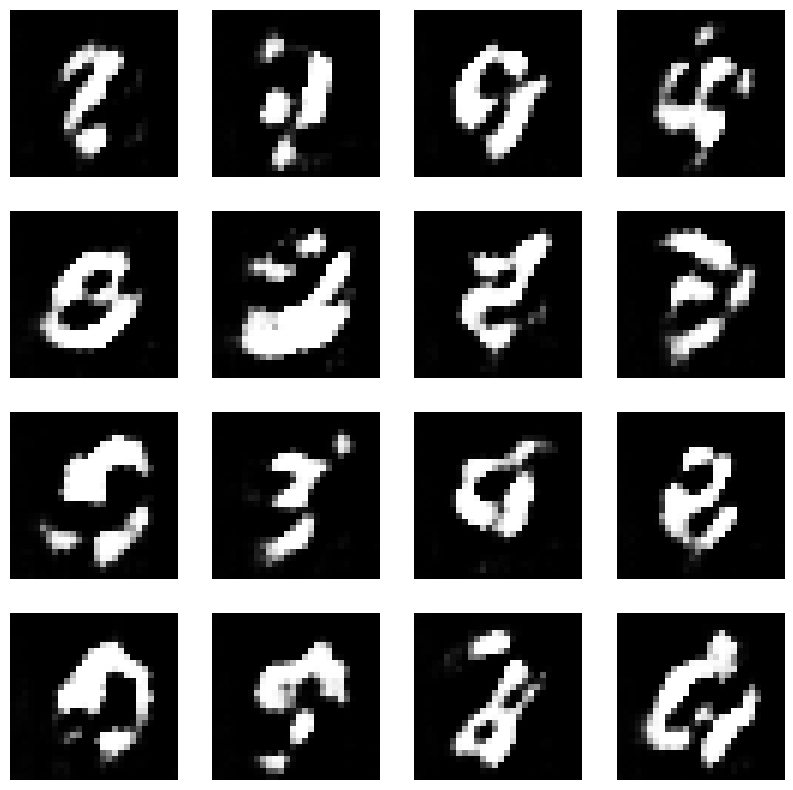

Epoch:  30


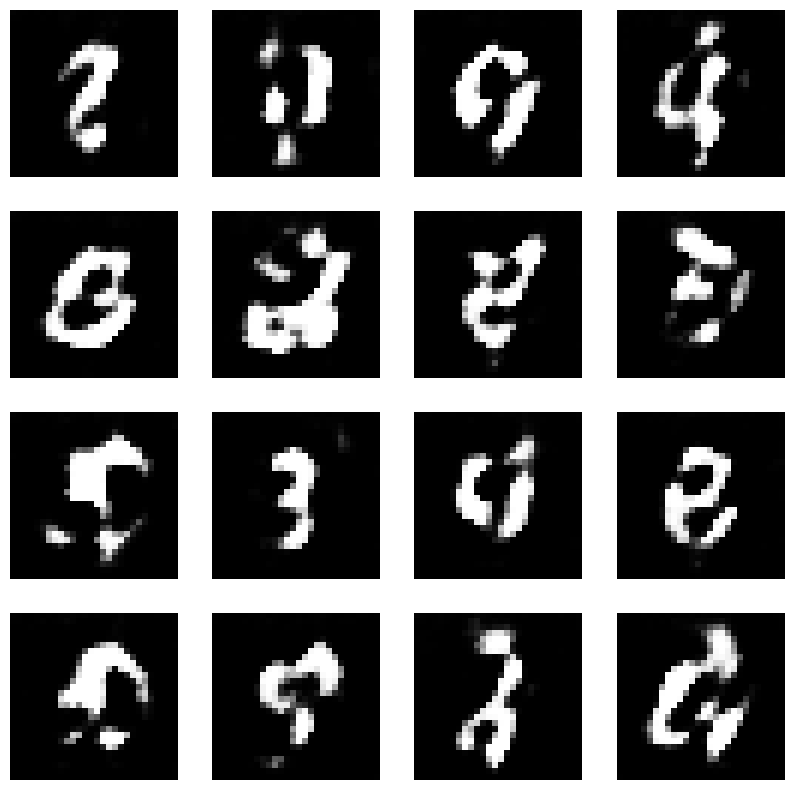

Epoch:  31


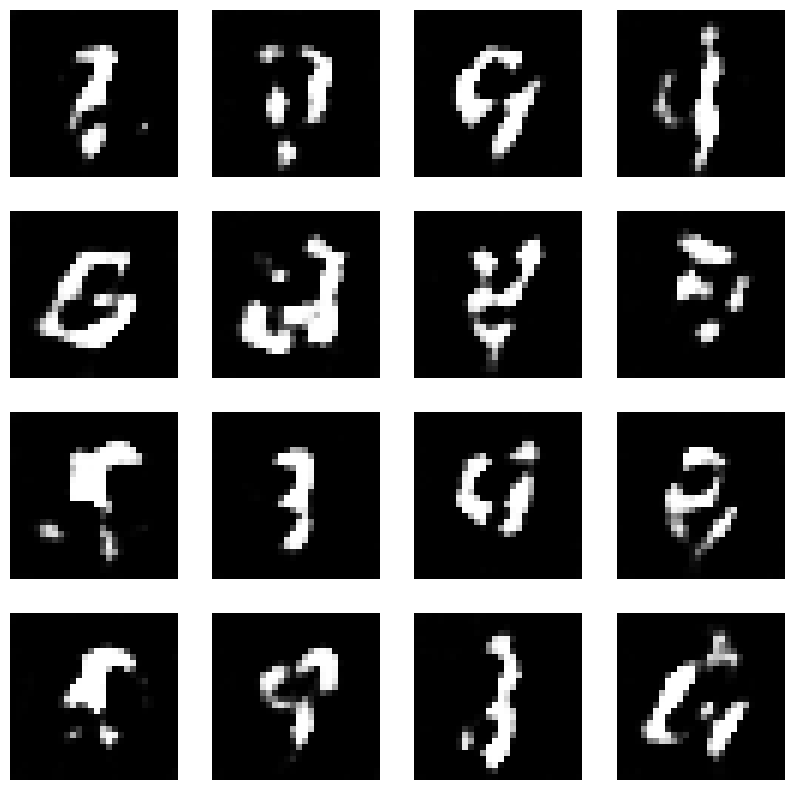

Epoch:  32


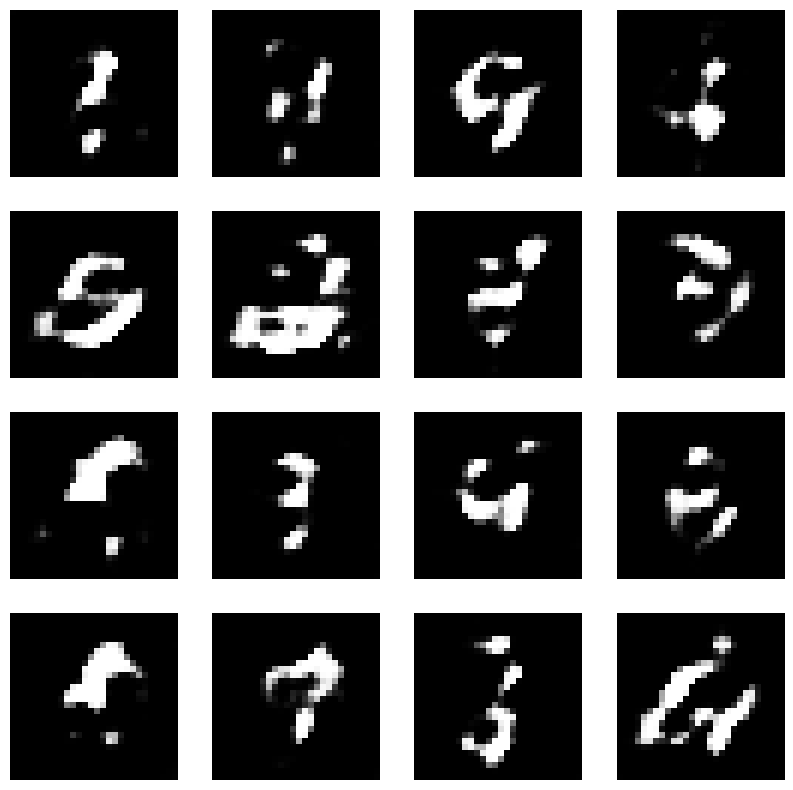

Epoch:  33


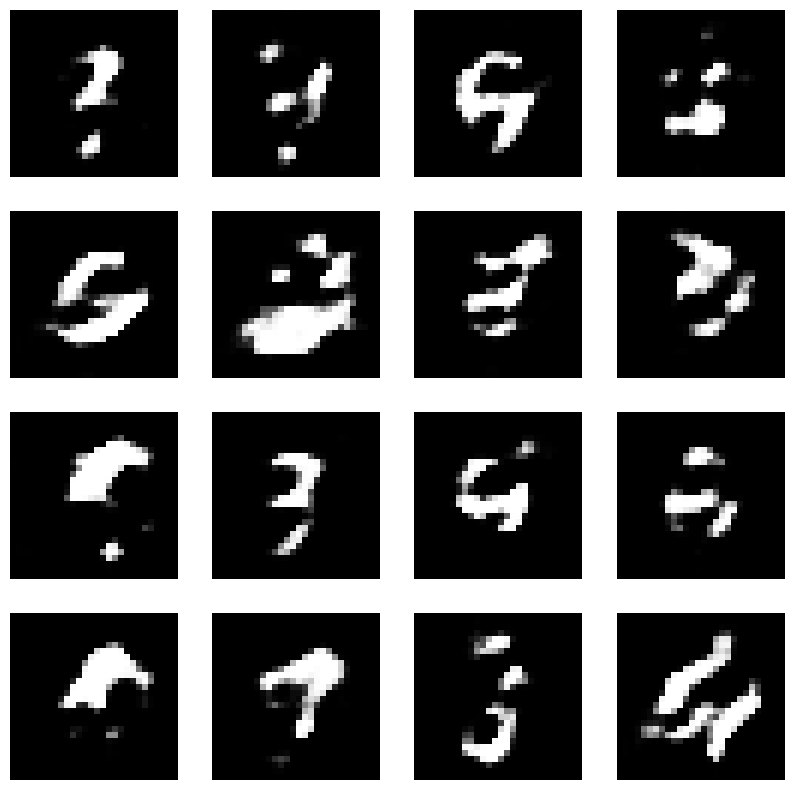

Epoch:  34


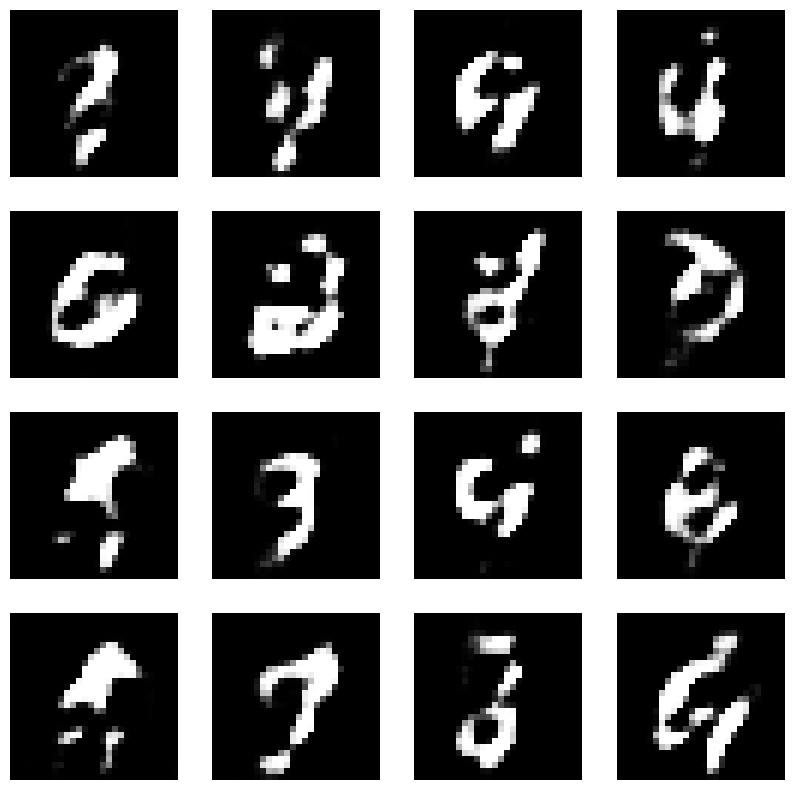

Epoch:  35


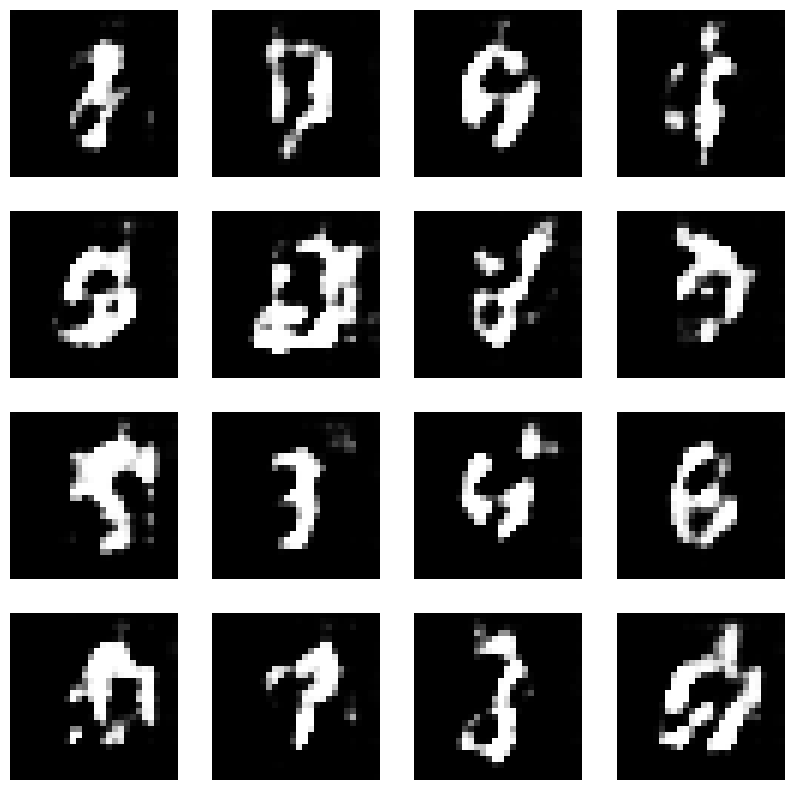

Epoch:  36


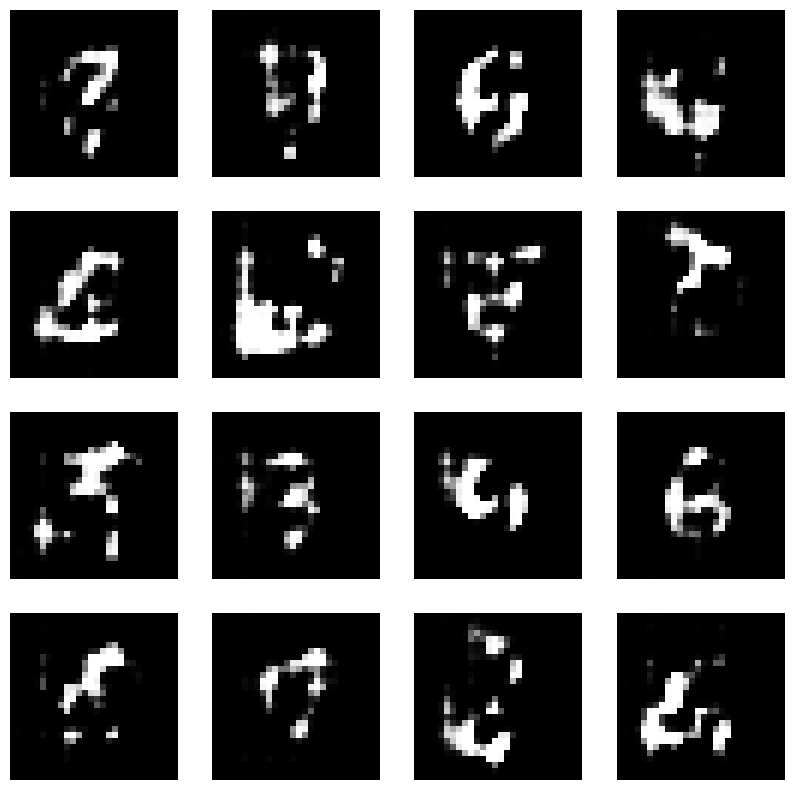

Epoch:  37


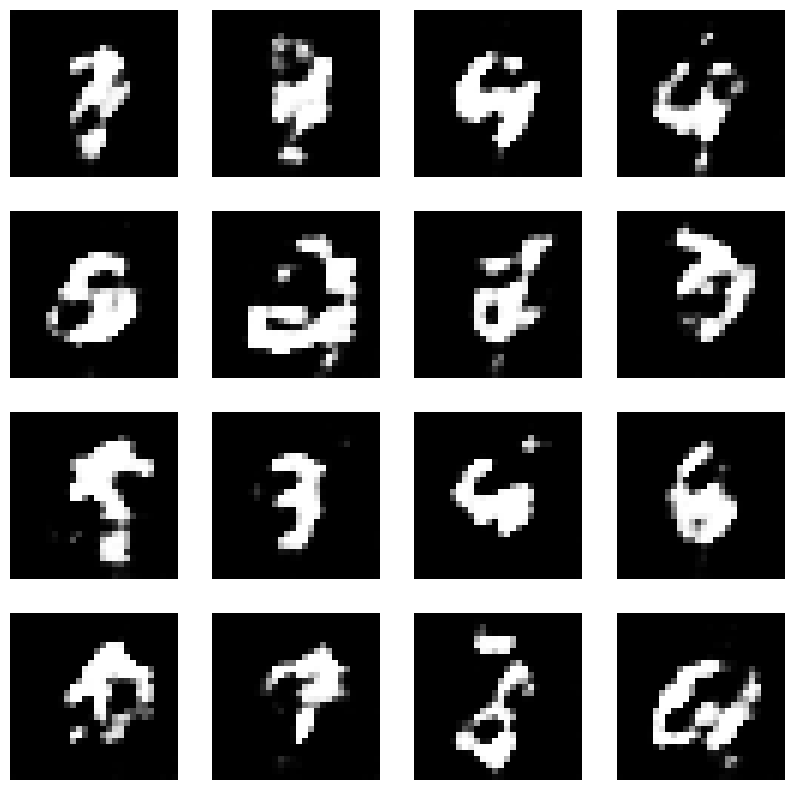

Epoch:  38


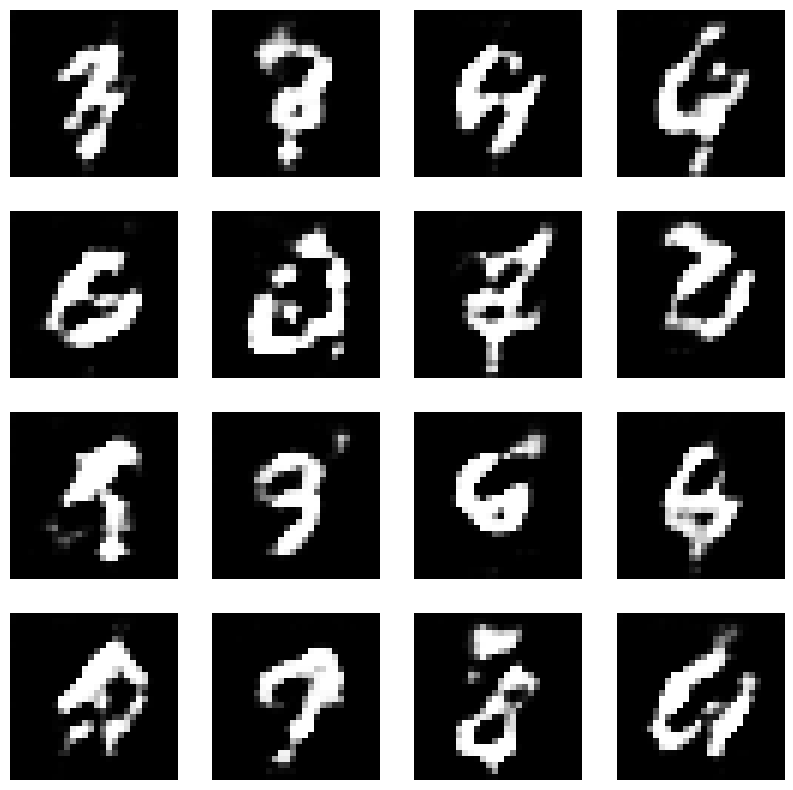

Epoch:  39


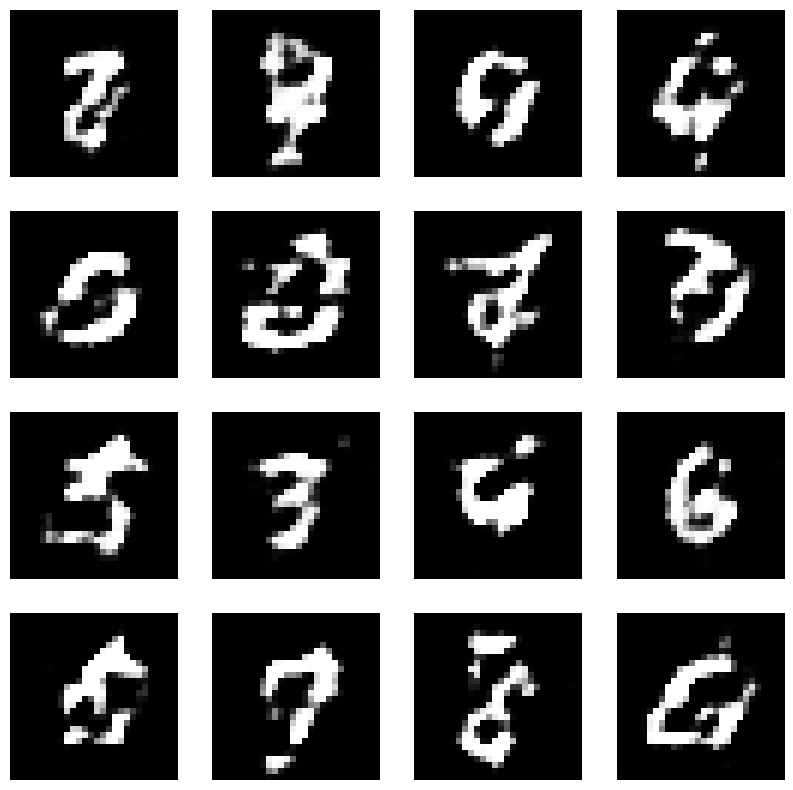

Epoch:  40


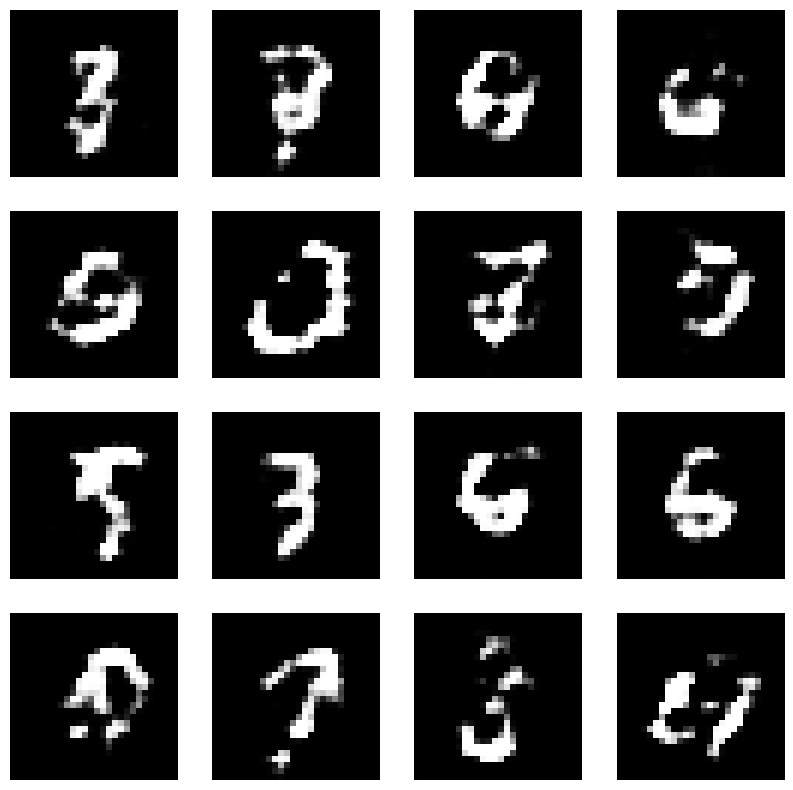

Epoch:  41


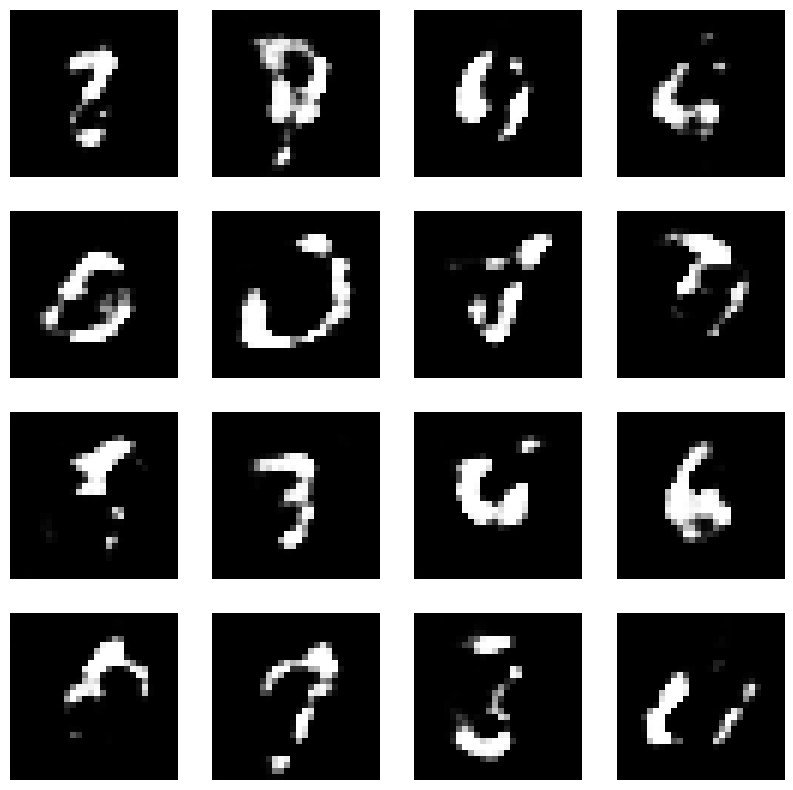

Epoch:  42


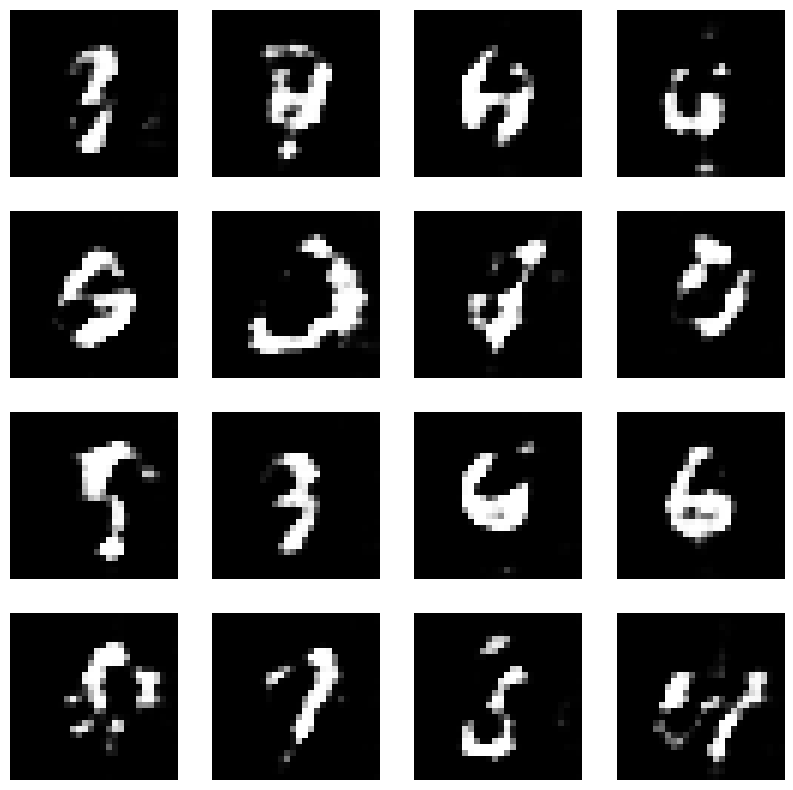

Epoch:  43


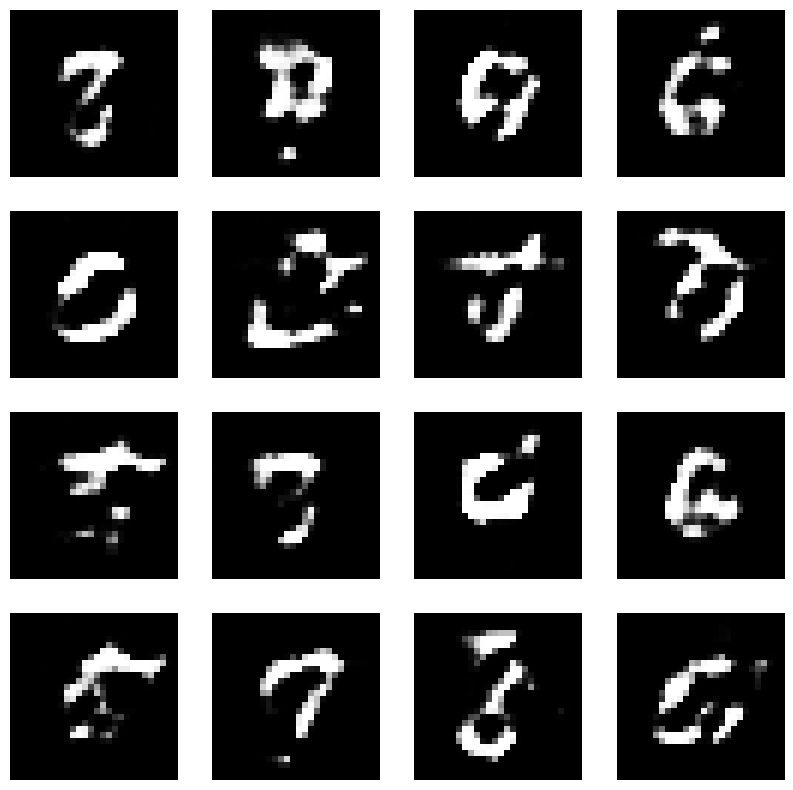

Epoch:  44


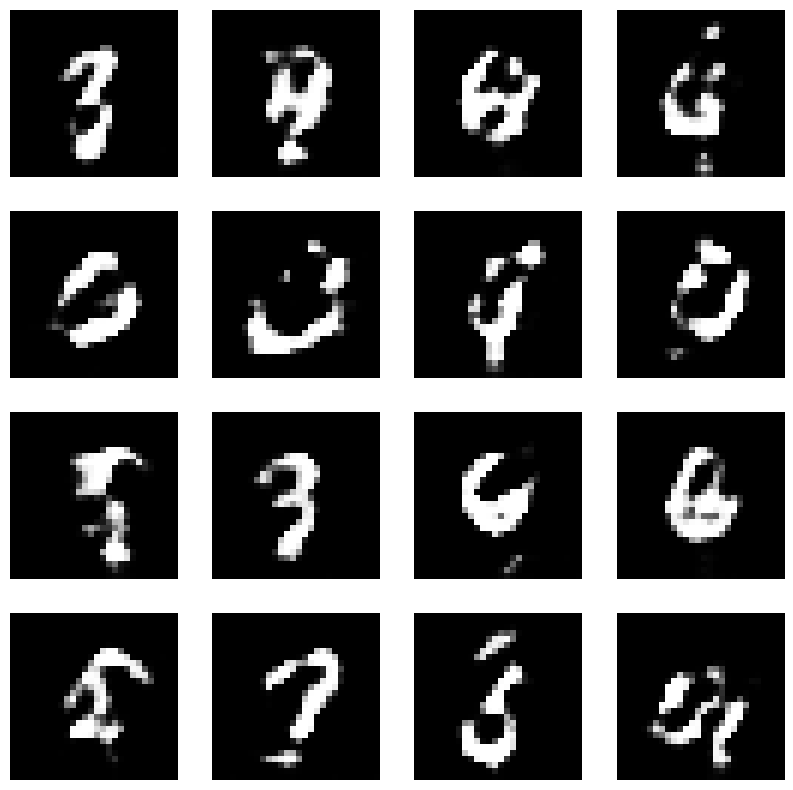

Epoch:  45


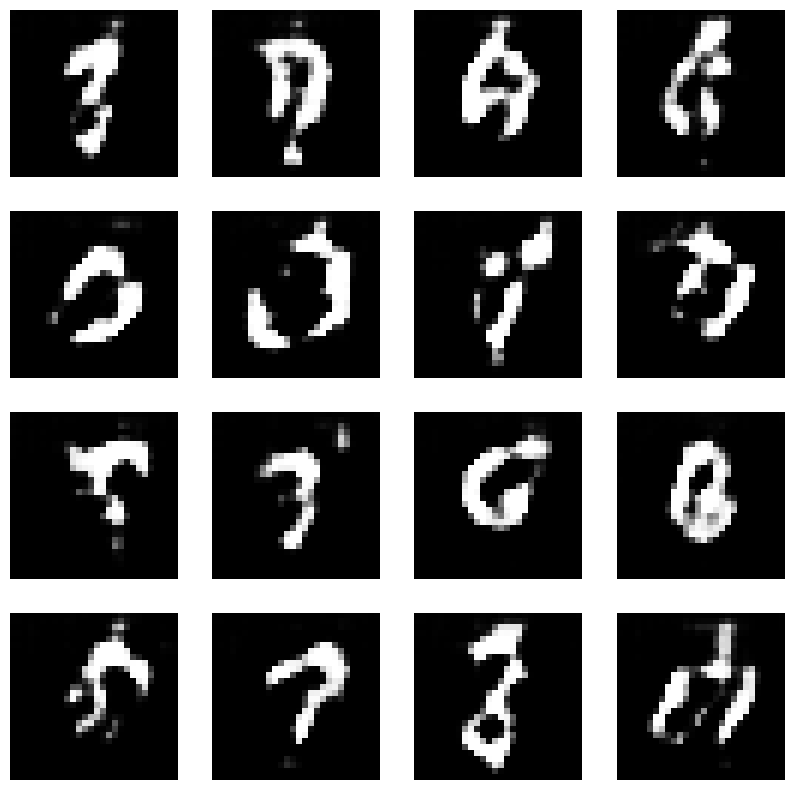

Epoch:  46


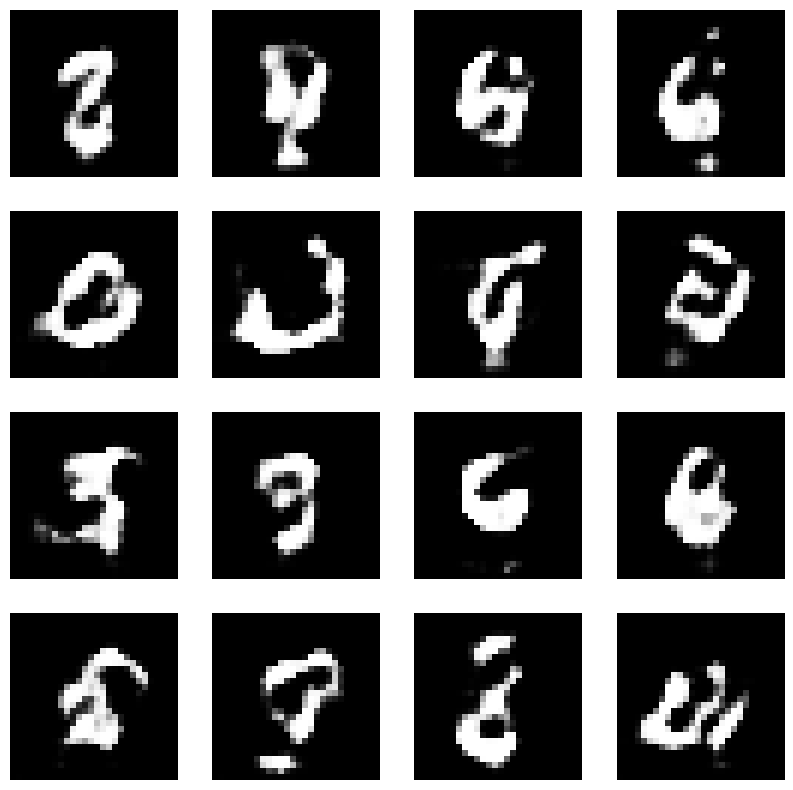

Epoch:  47


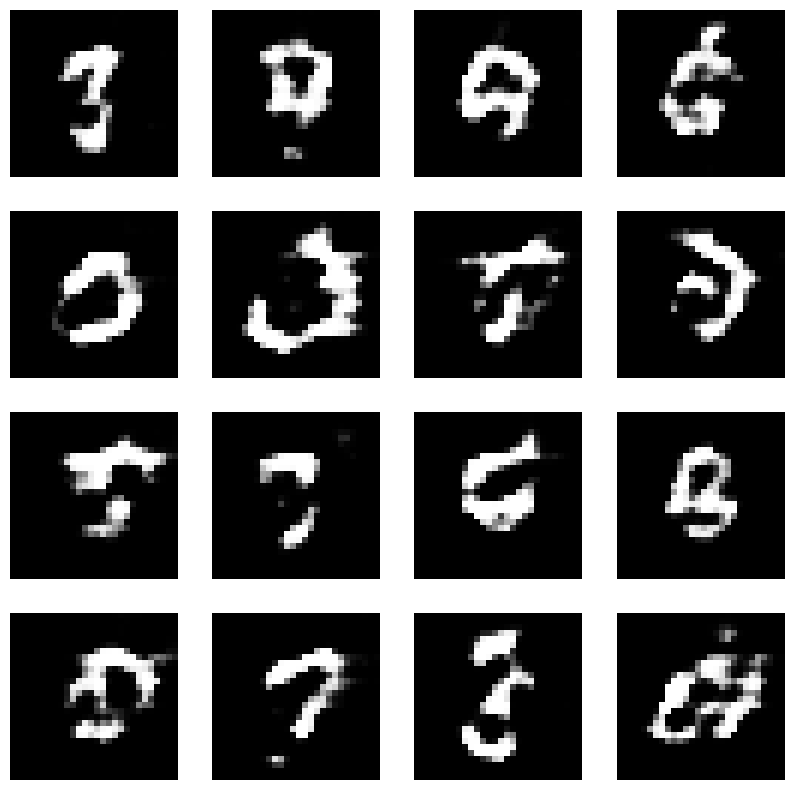

Epoch:  48


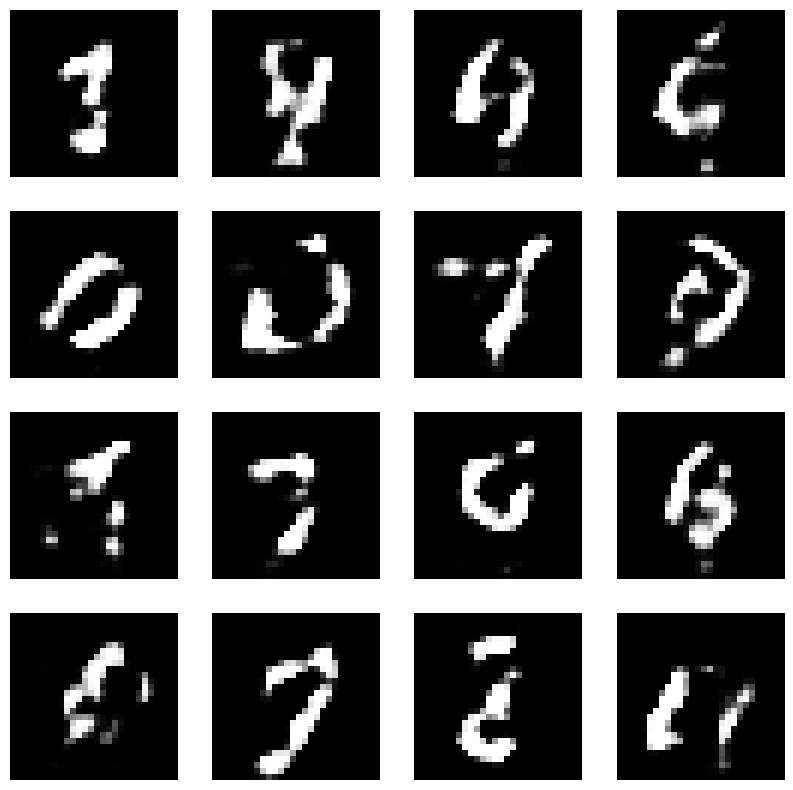

Epoch:  49


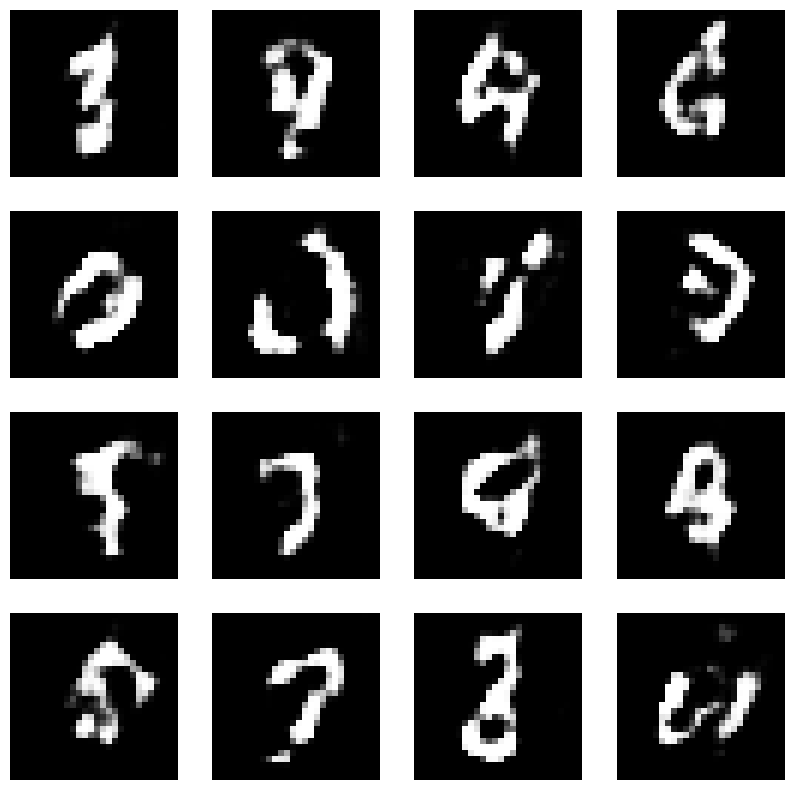

Epoch:  50


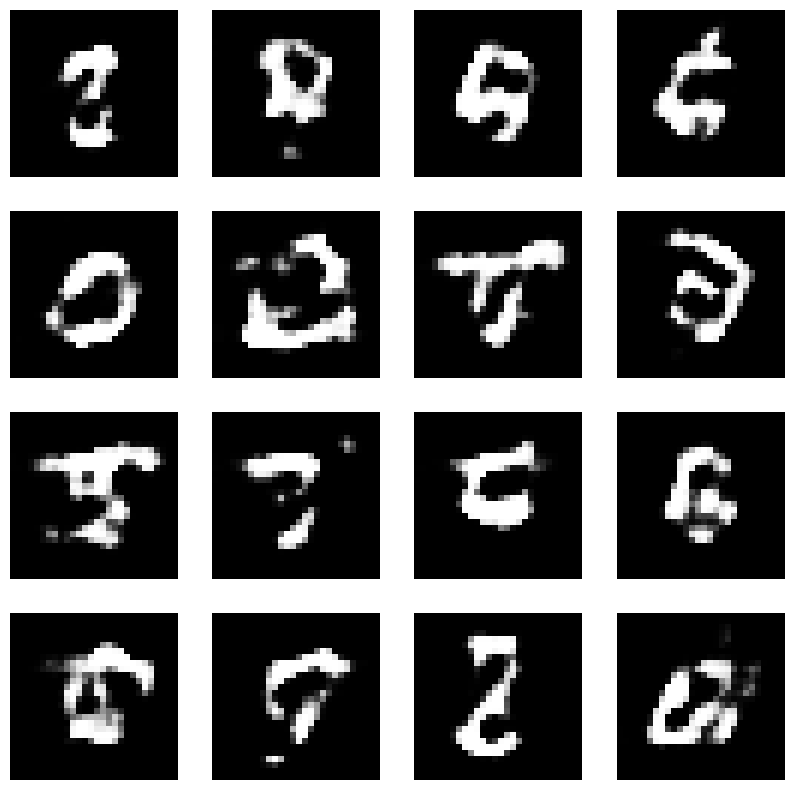

Epoch:  51


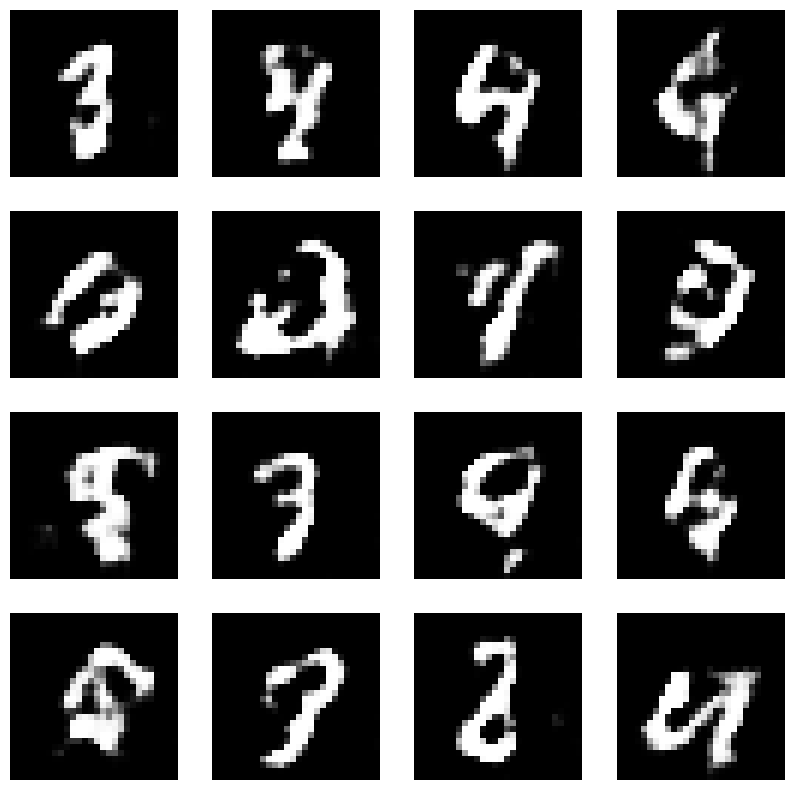

Epoch:  52


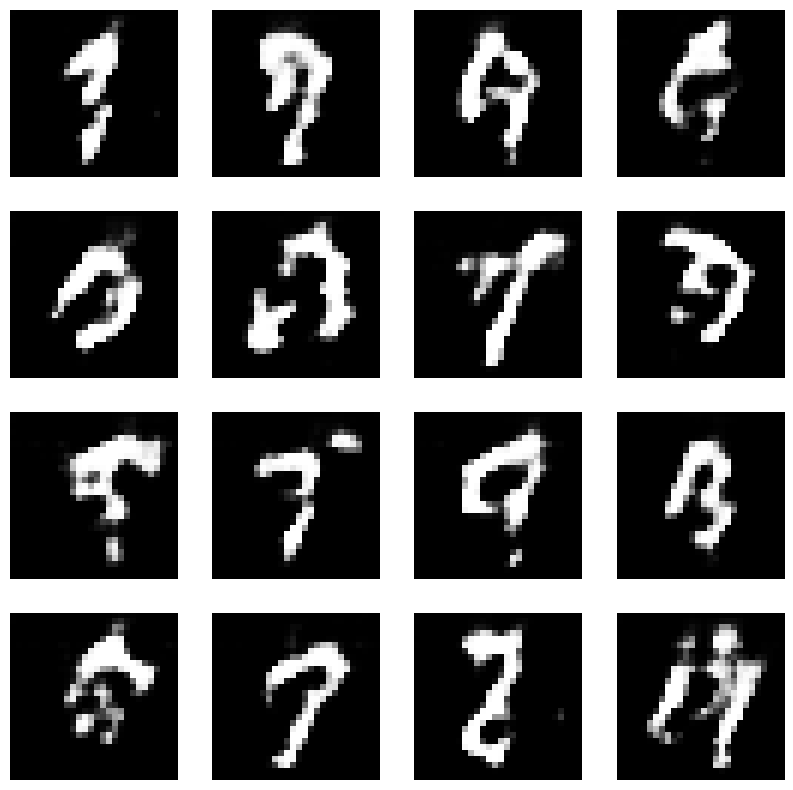

Epoch:  53


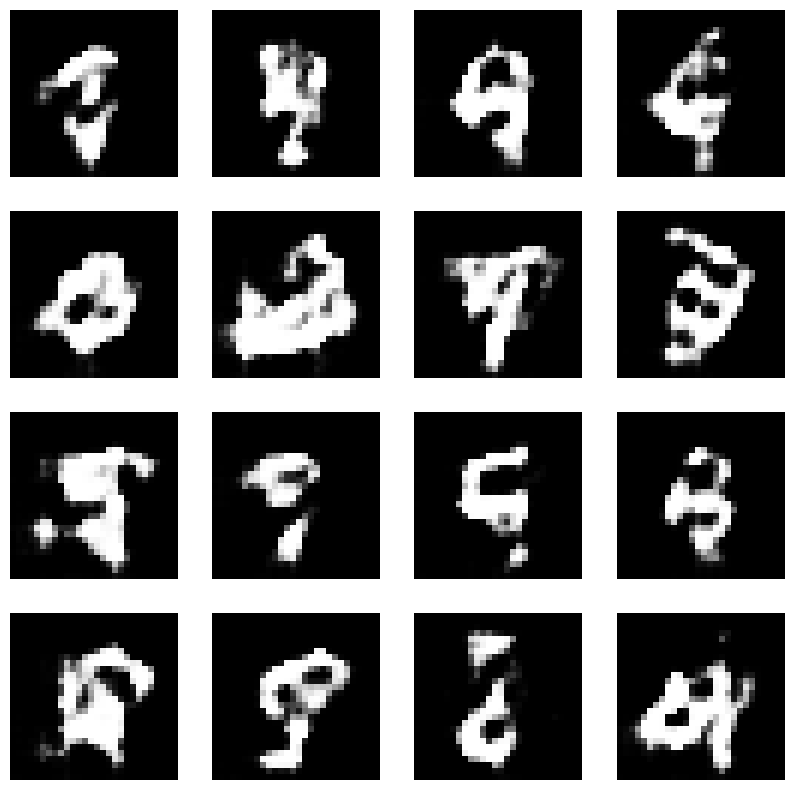

Epoch:  54


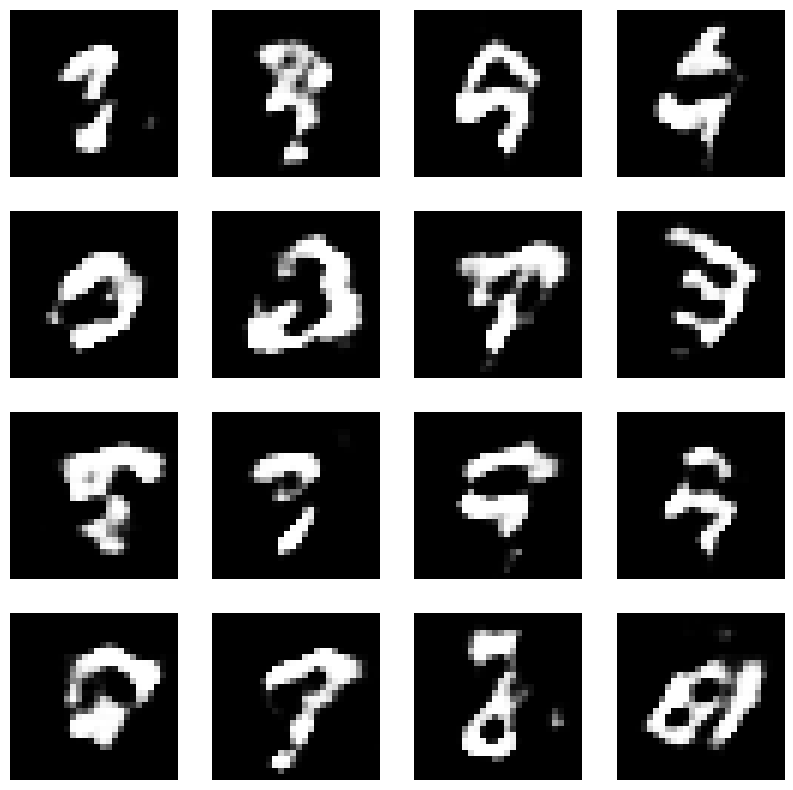

Epoch:  55


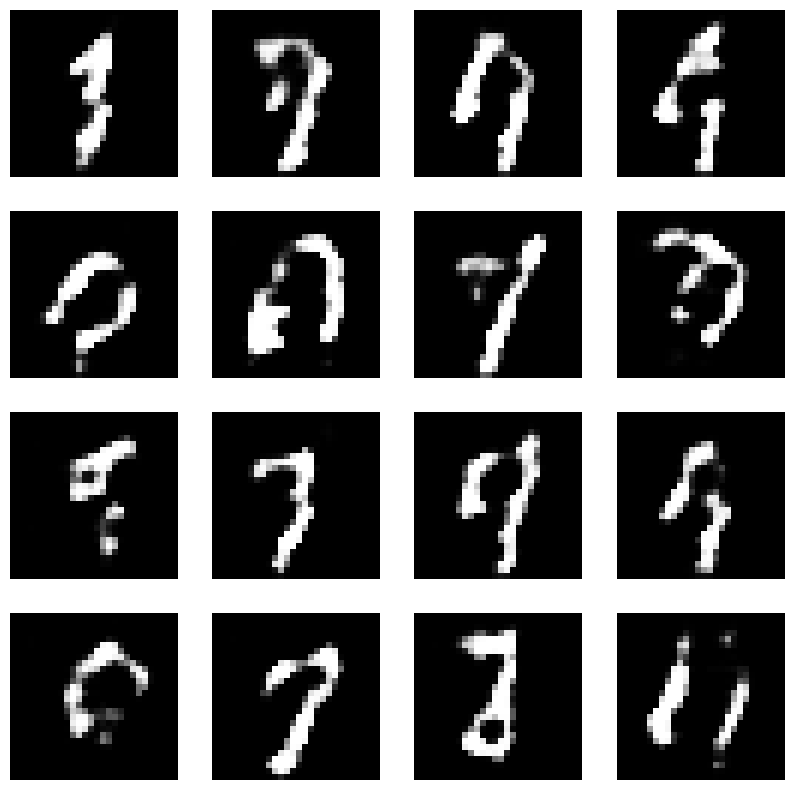

Epoch:  56


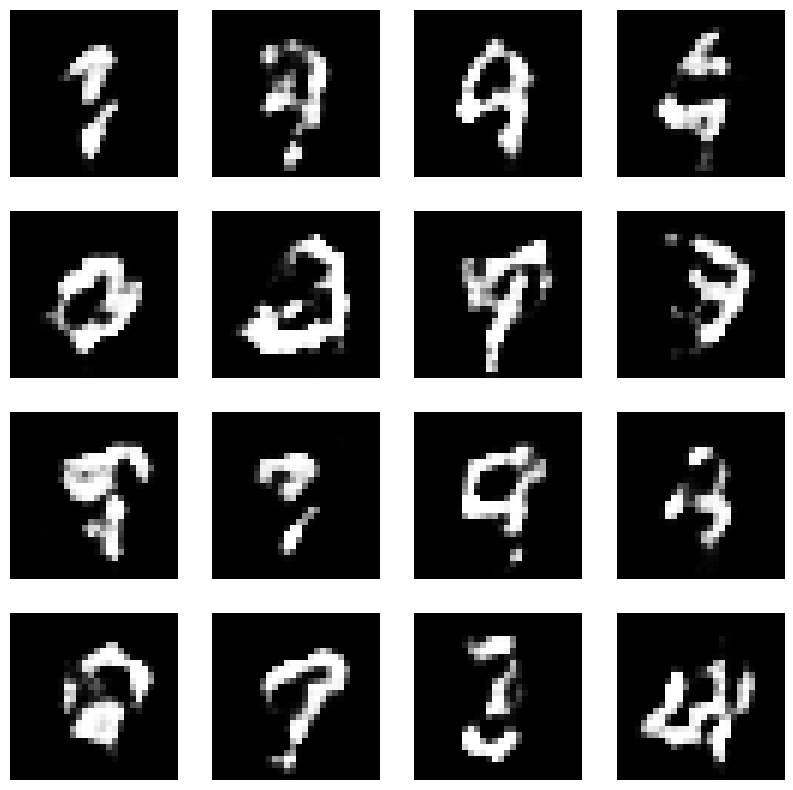

Epoch:  57


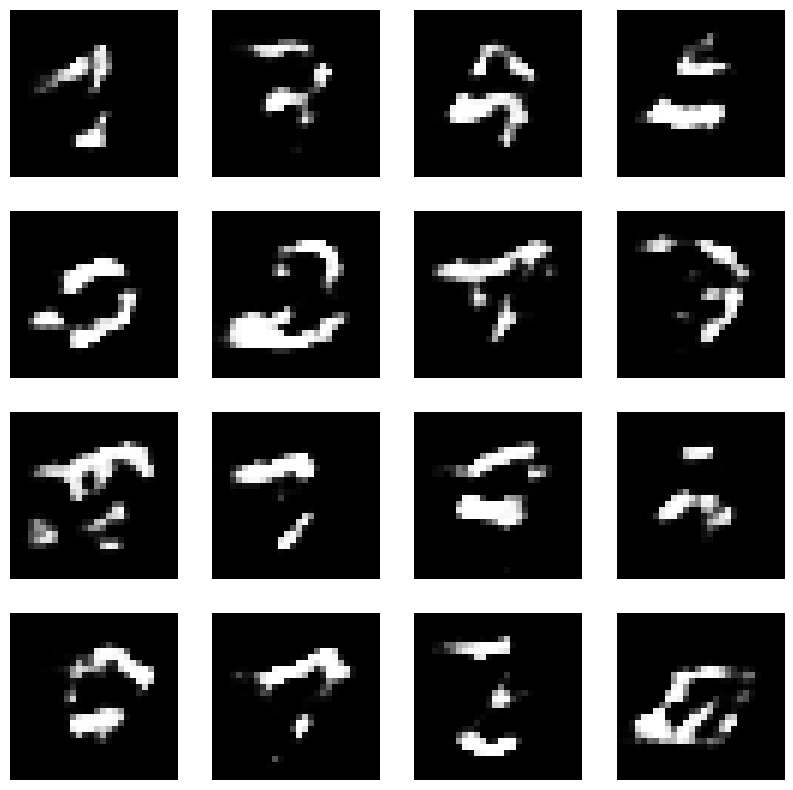

Epoch:  58


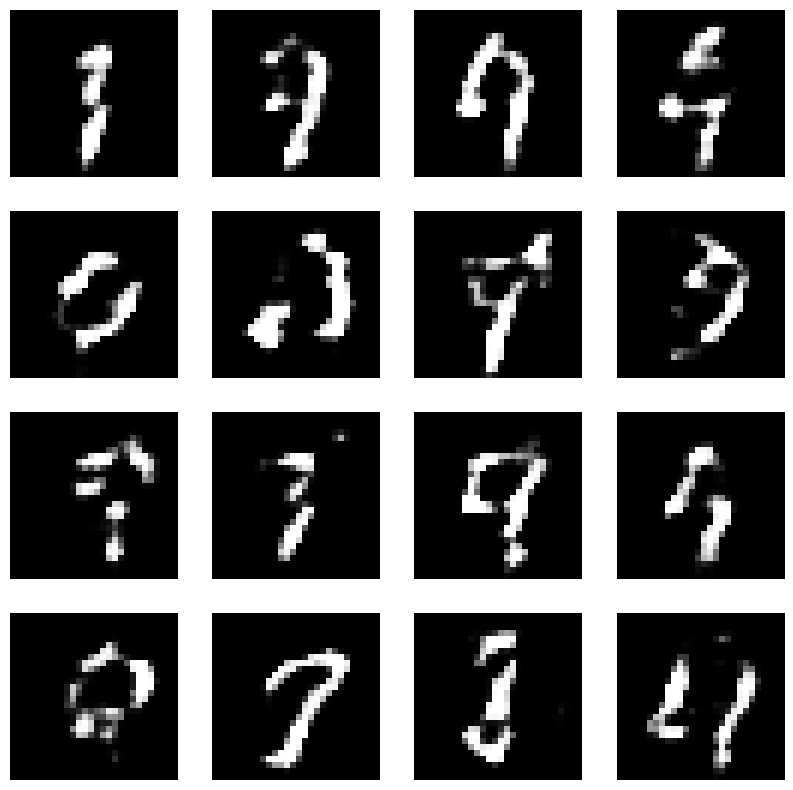

Epoch:  59


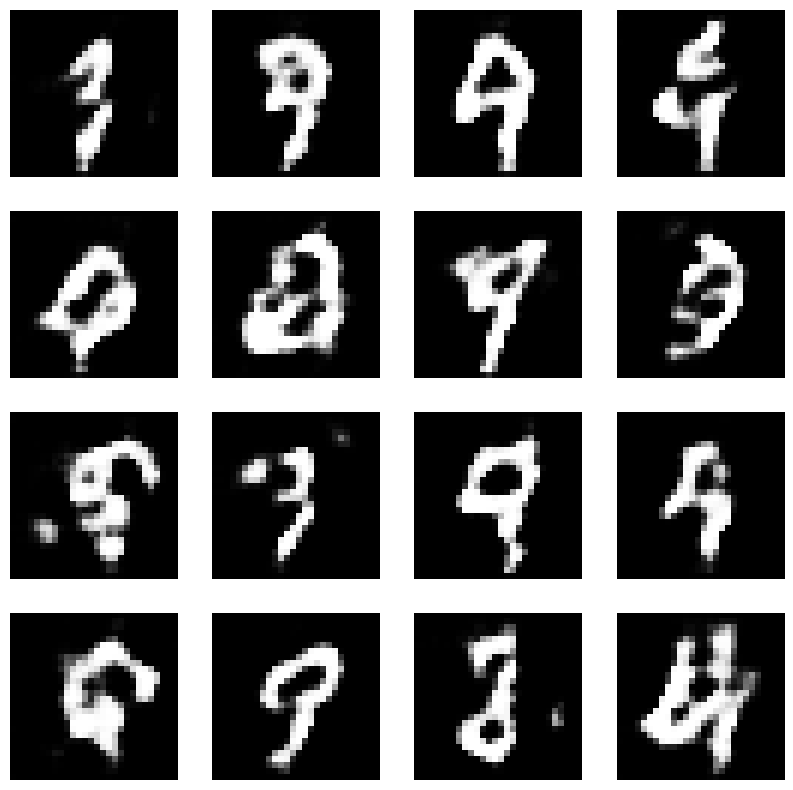

Epoch:  60


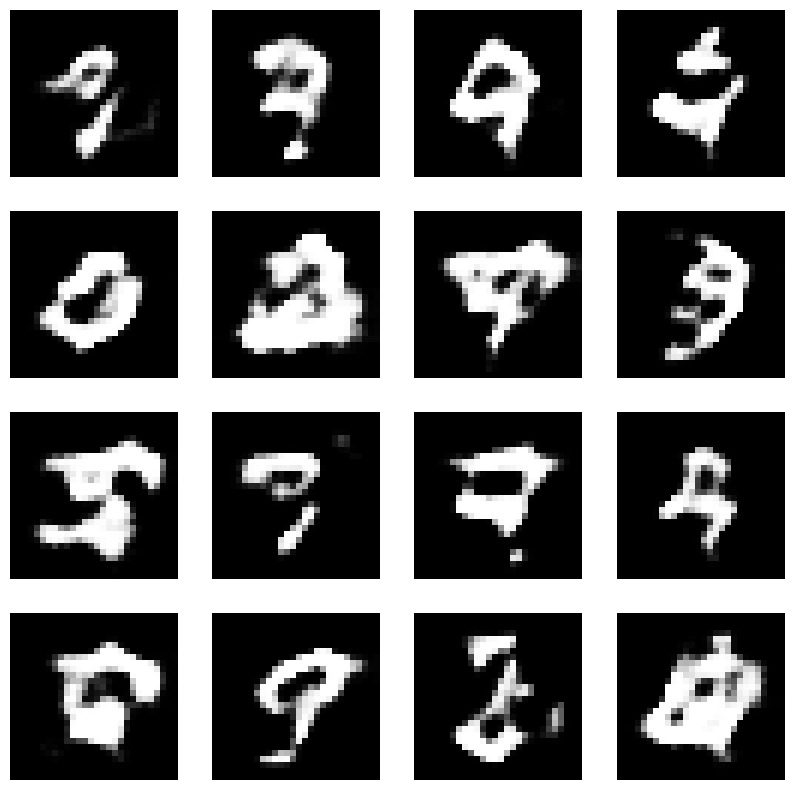

Epoch:  61


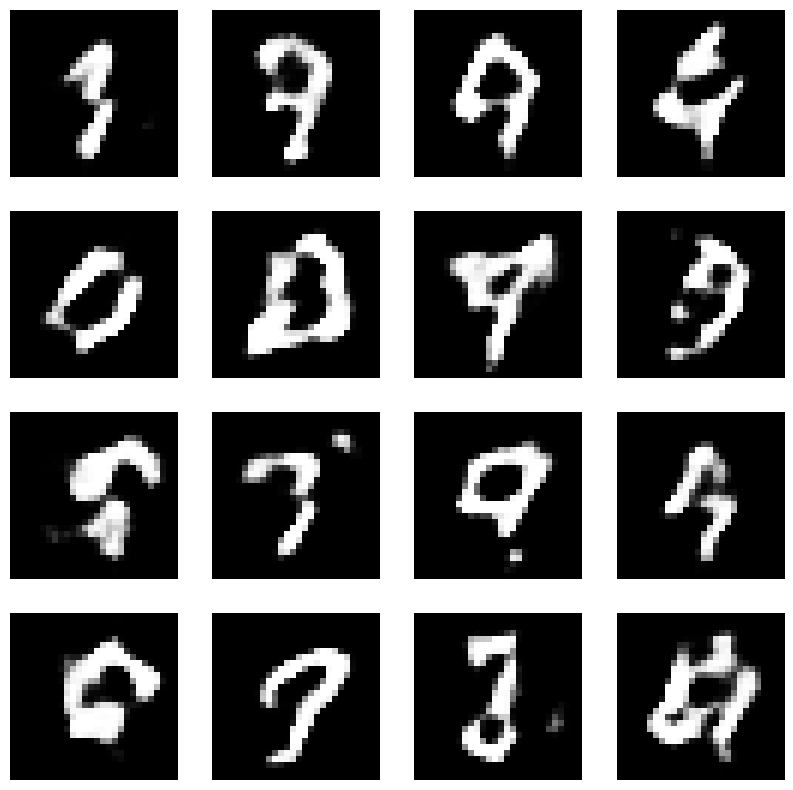

Epoch:  62


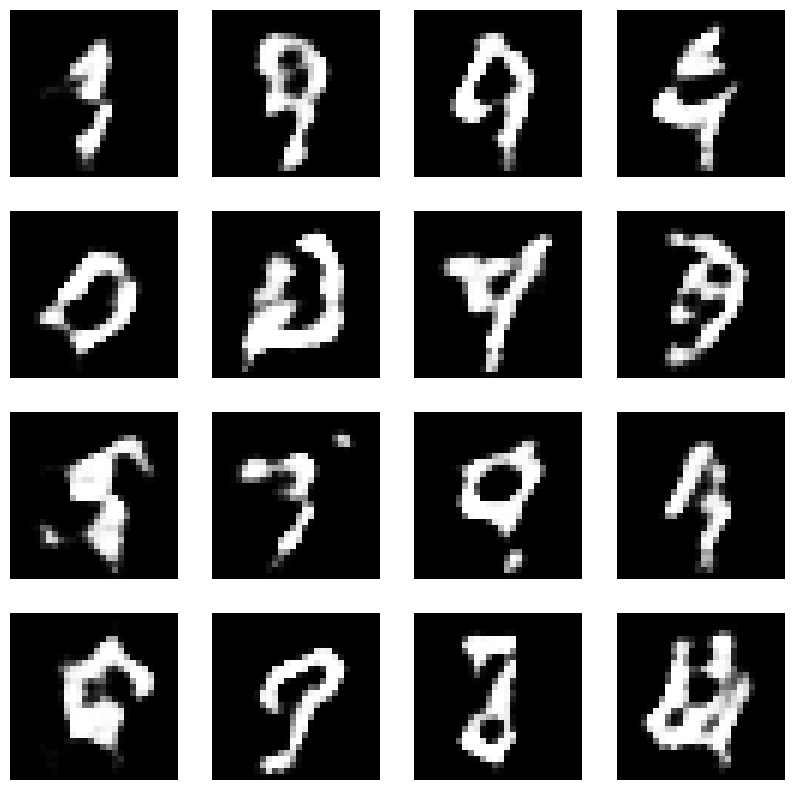

Epoch:  63


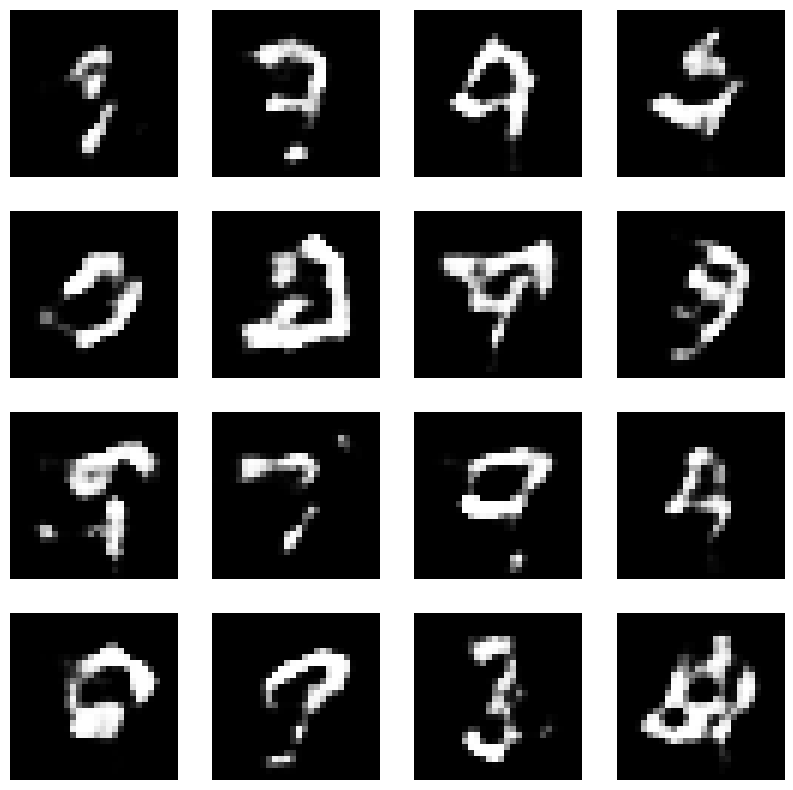

Epoch:  64


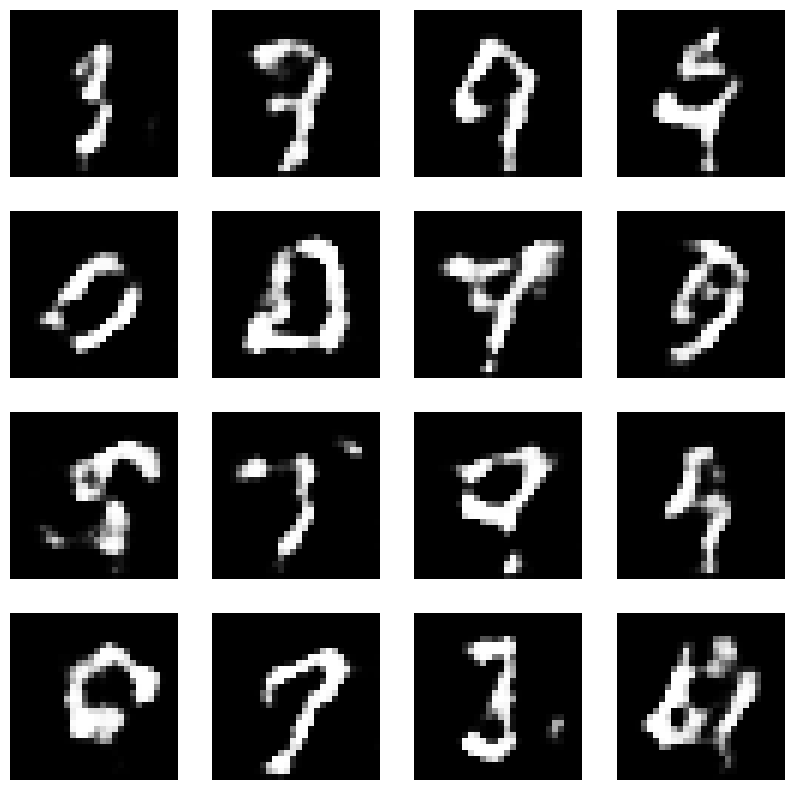

Epoch:  65


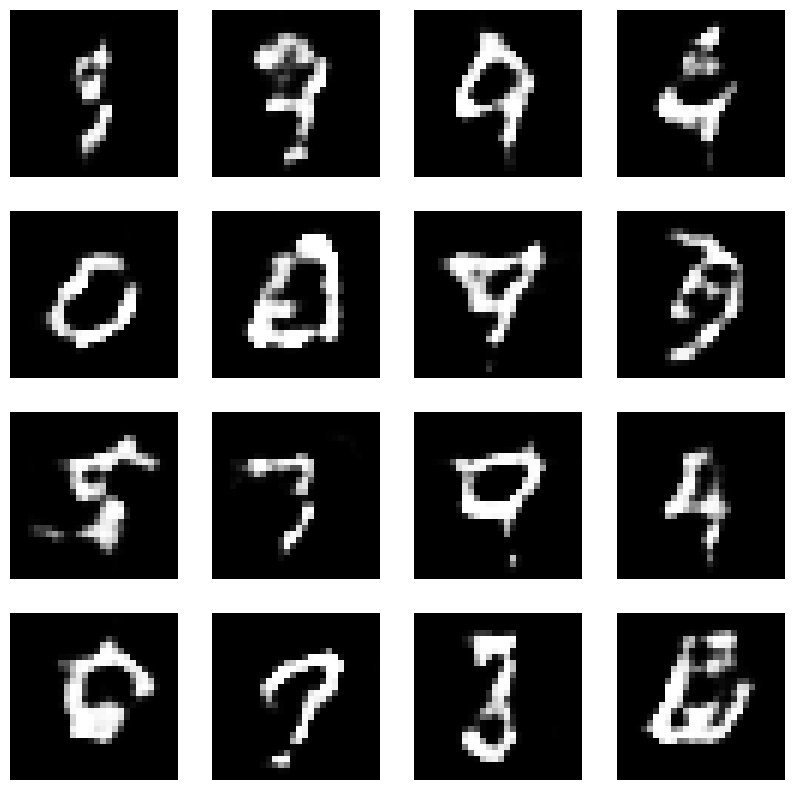

Epoch:  66


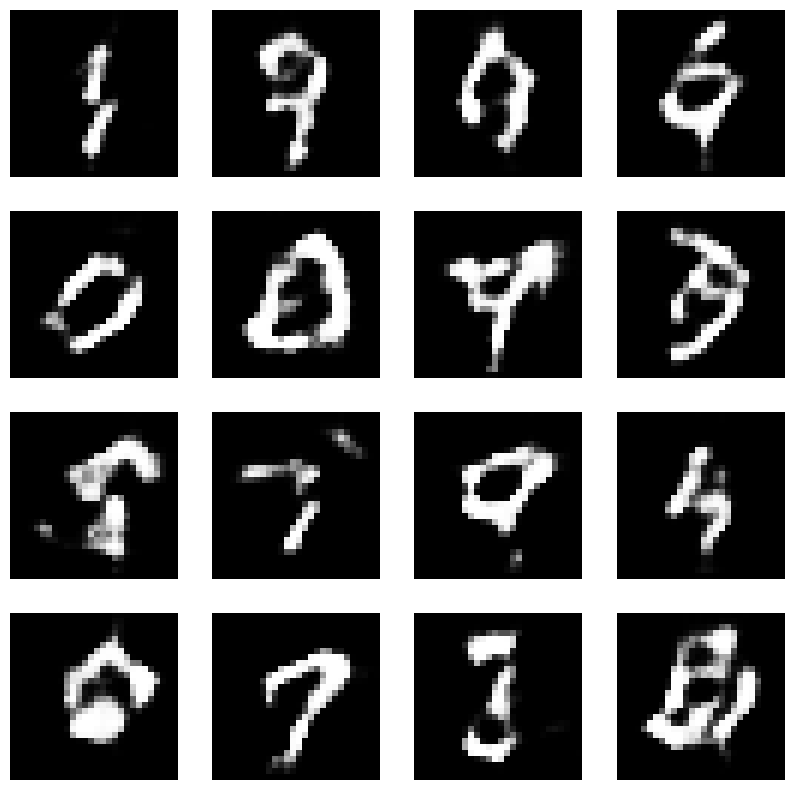

Epoch:  67


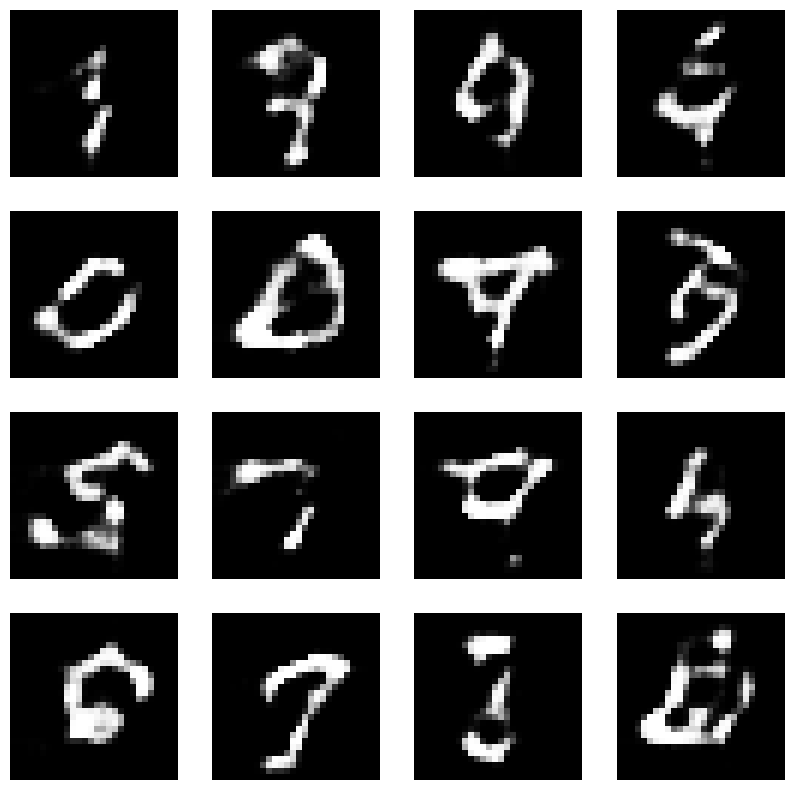

Epoch:  68


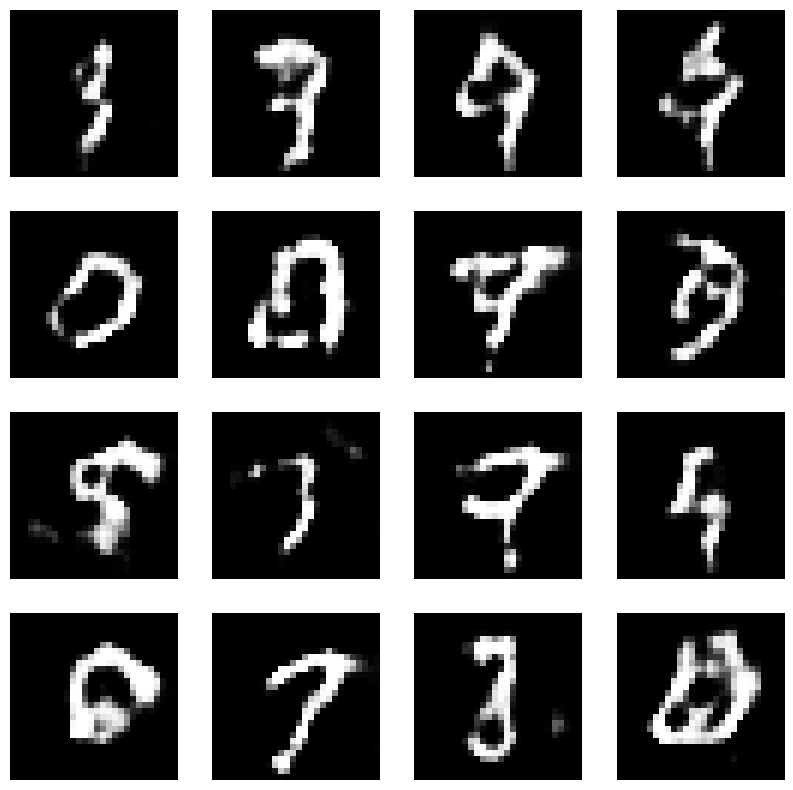

Epoch:  69


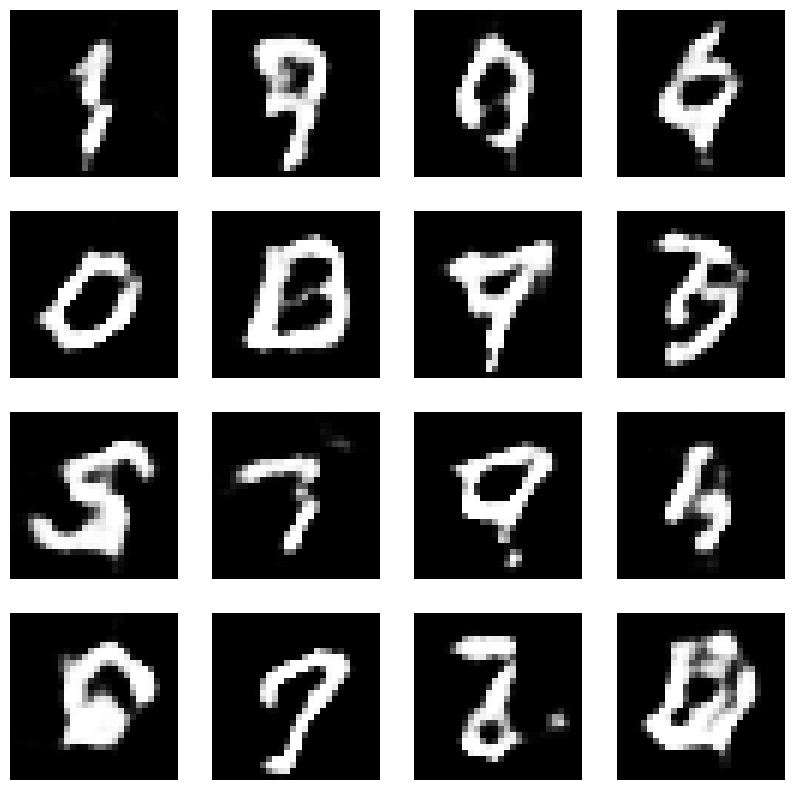

Epoch:  70


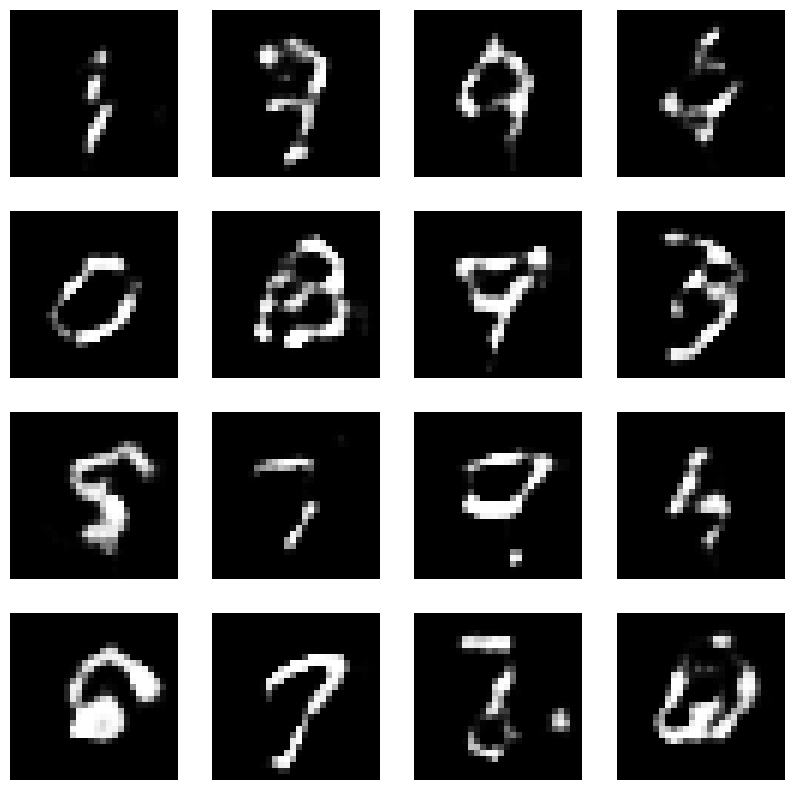

Epoch:  71


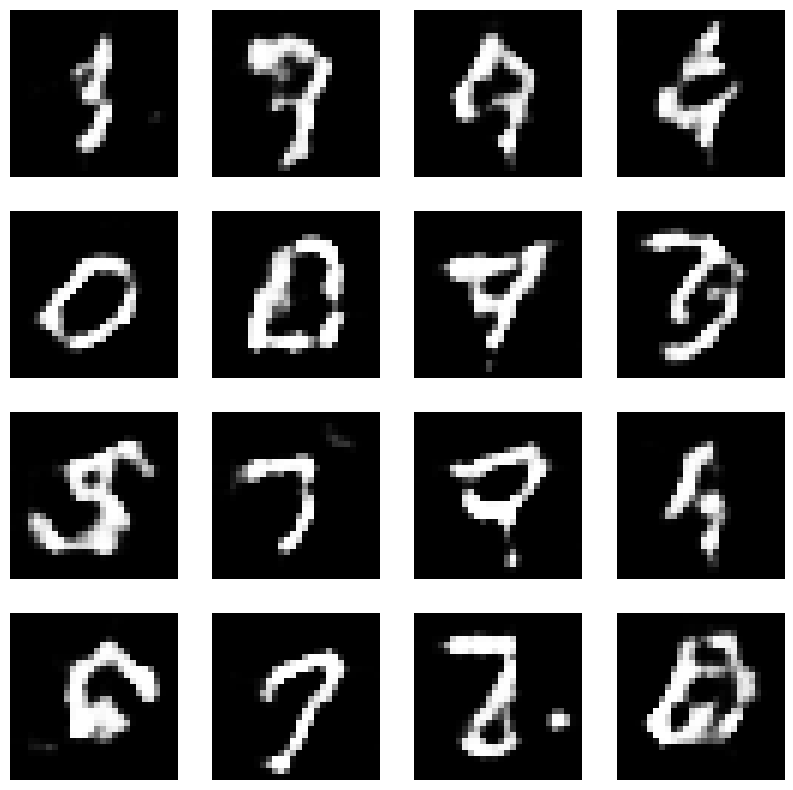

Epoch:  72


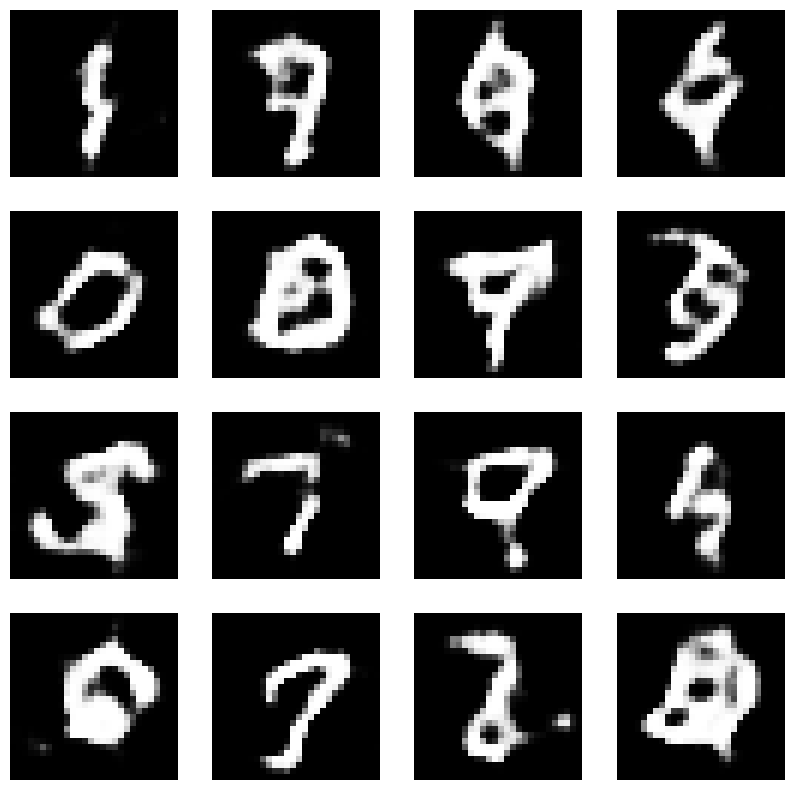

Epoch:  73


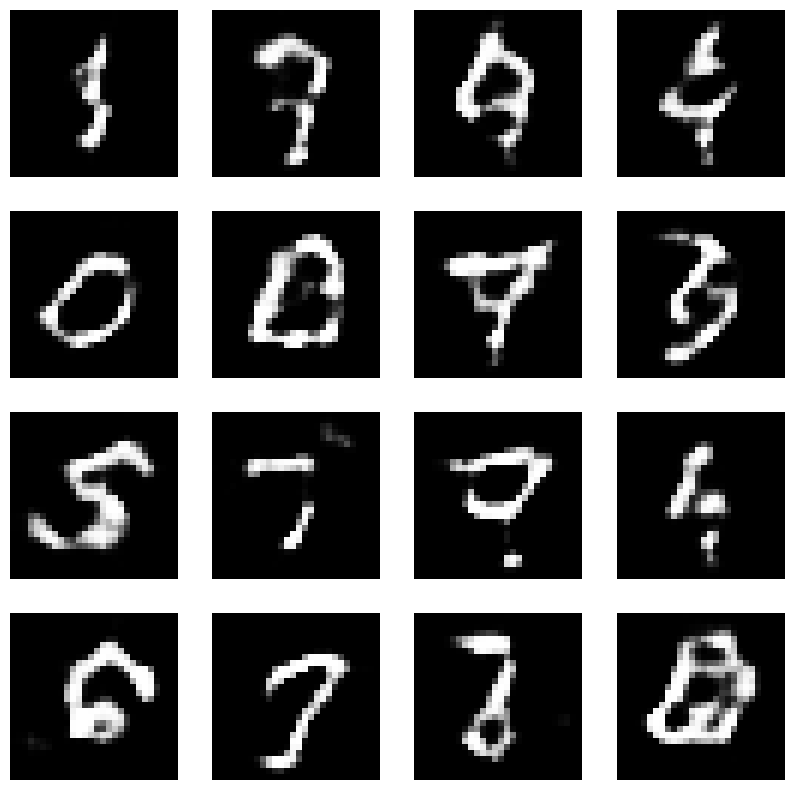

Epoch:  74


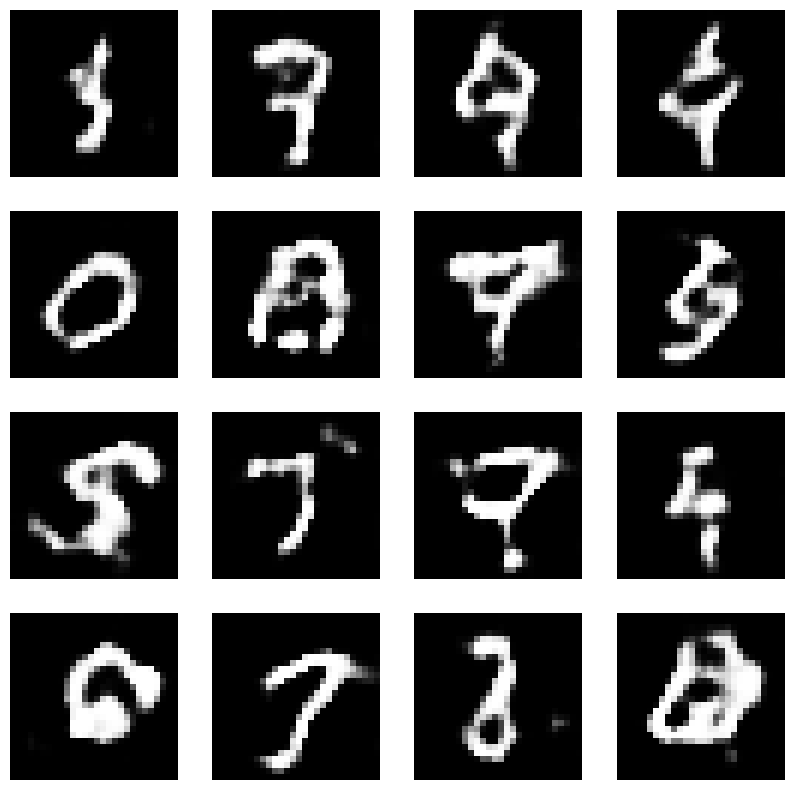

Epoch:  75


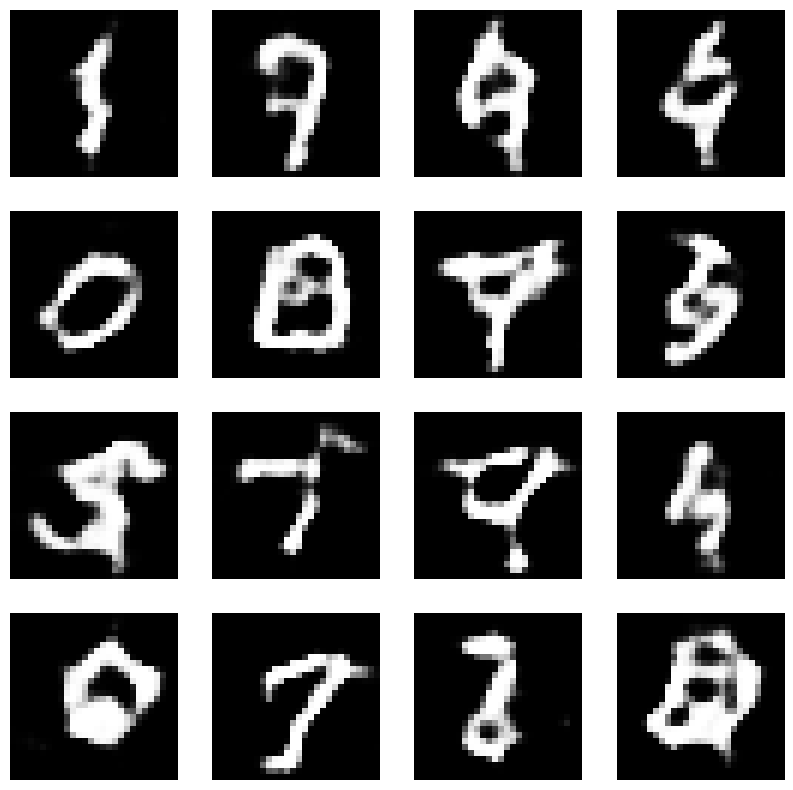

Epoch:  76


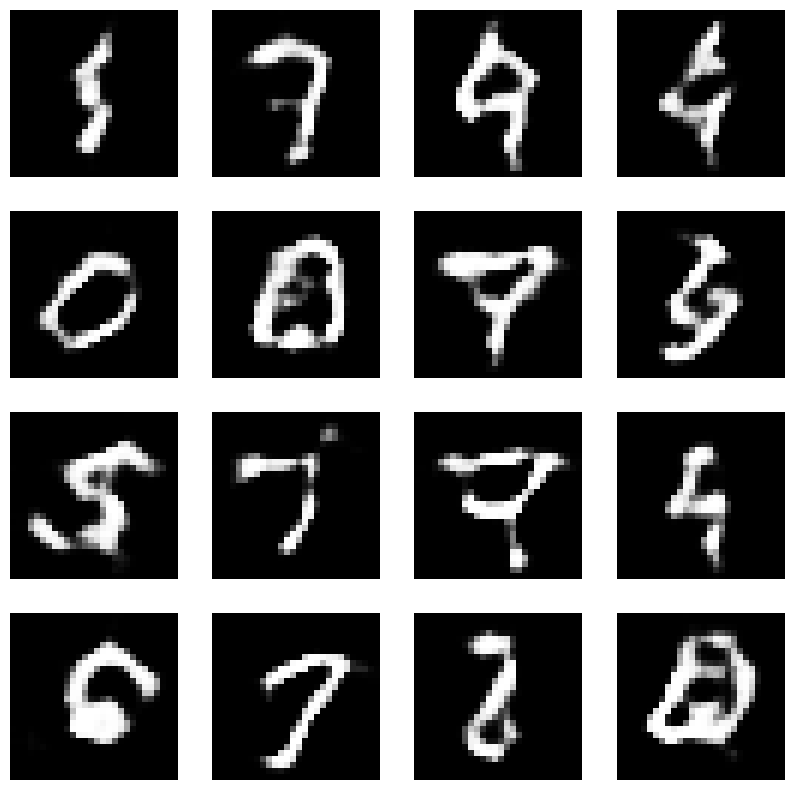

Epoch:  77


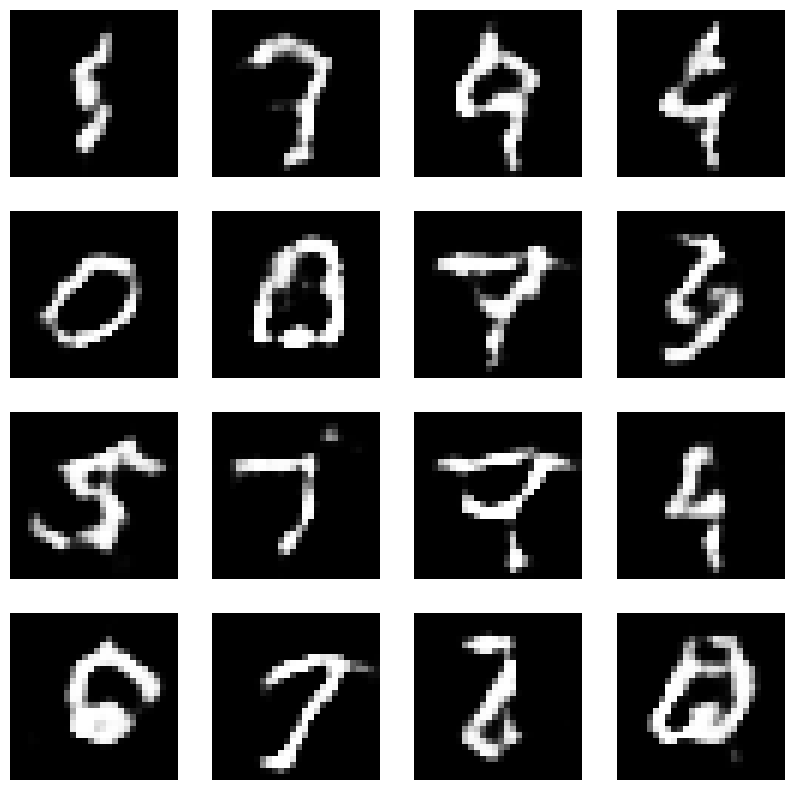

Epoch:  78


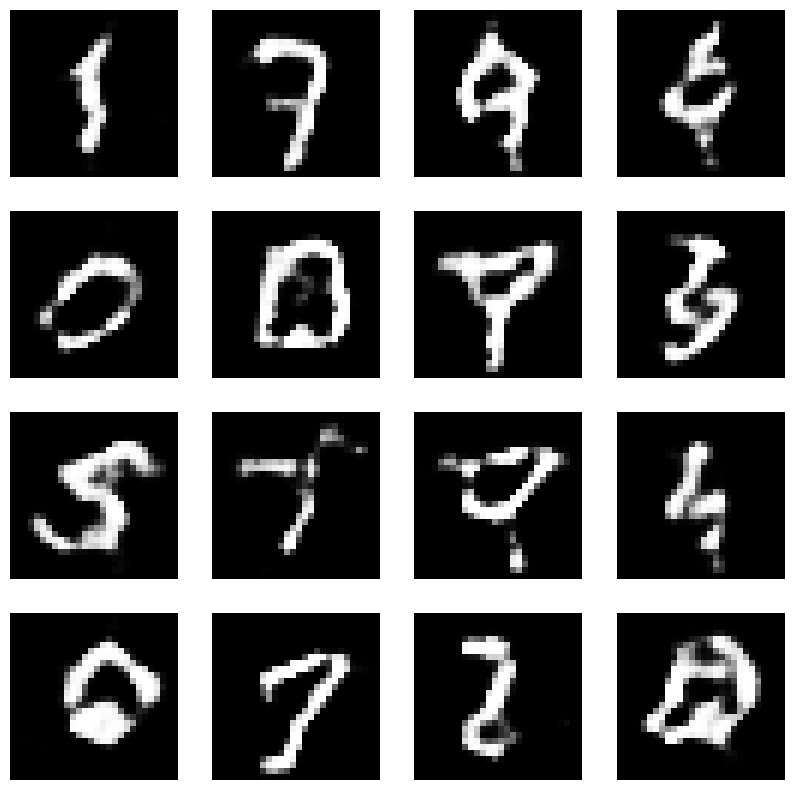

Epoch:  79


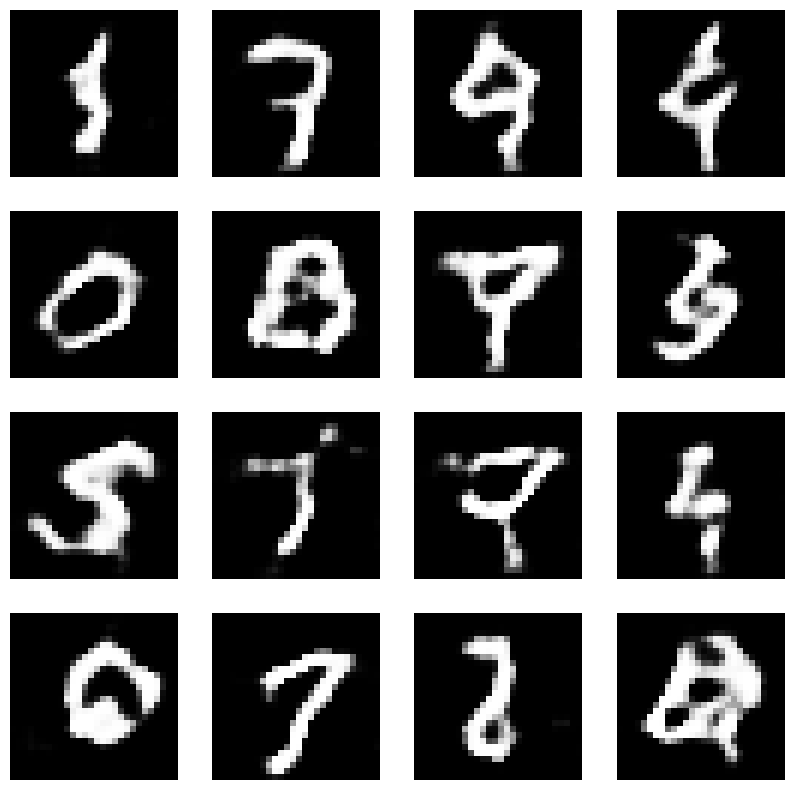

Epoch:  80


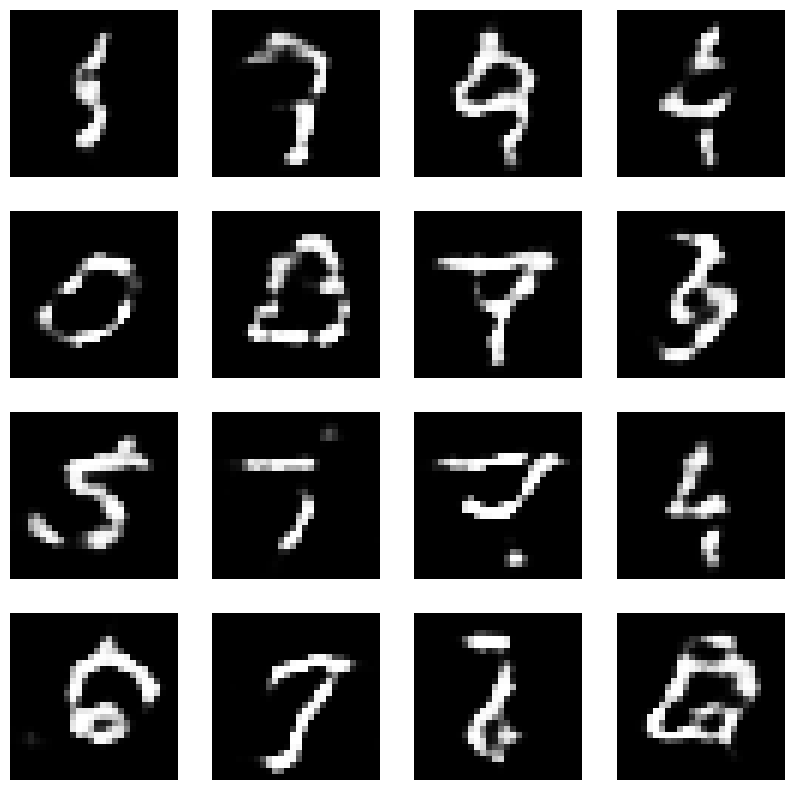

Epoch:  81


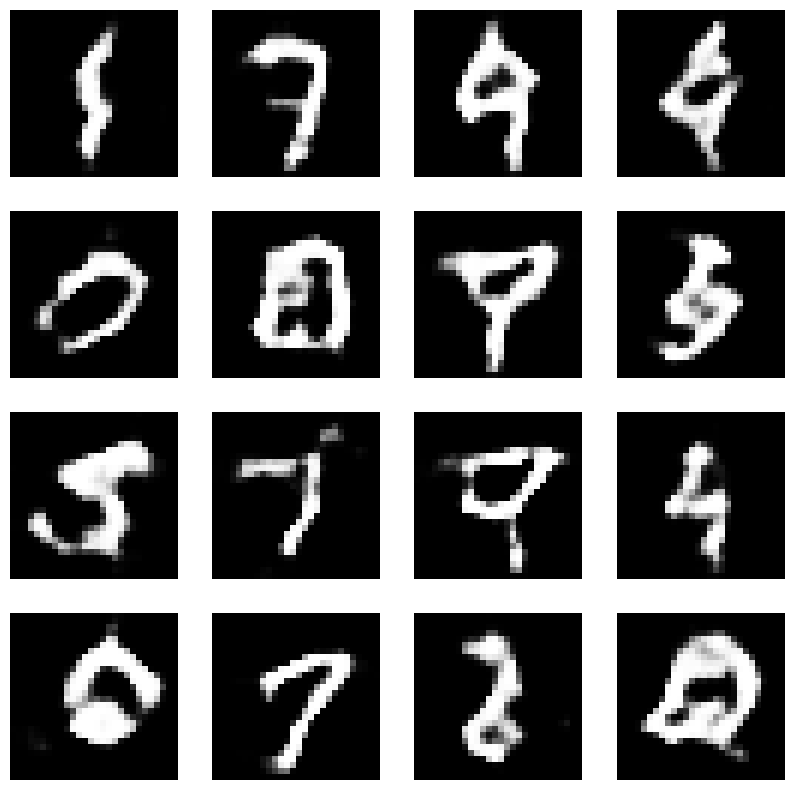

Epoch:  82


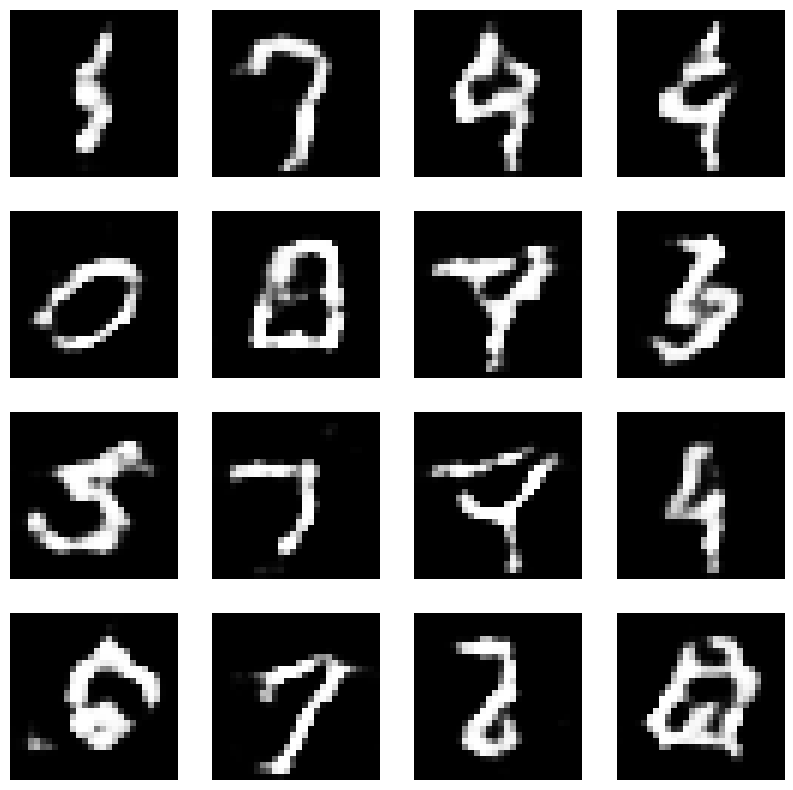

Epoch:  83


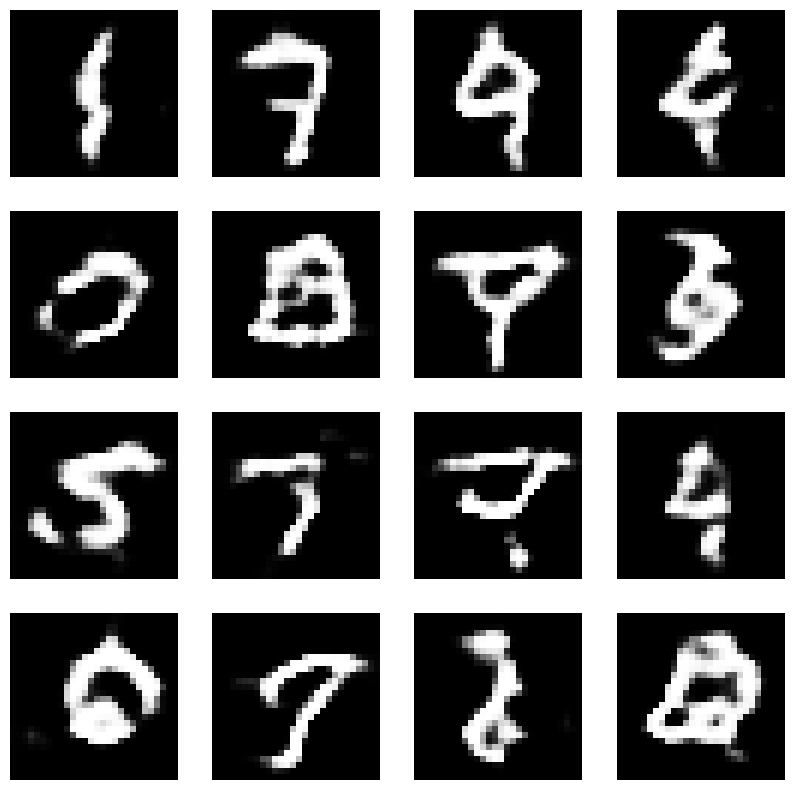

Epoch:  84


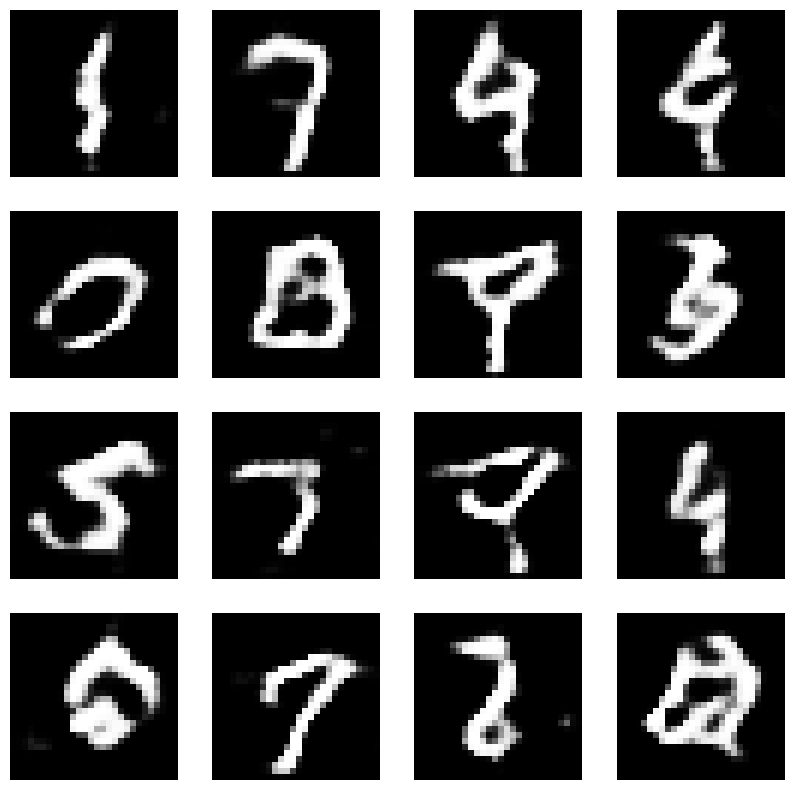

Epoch:  85


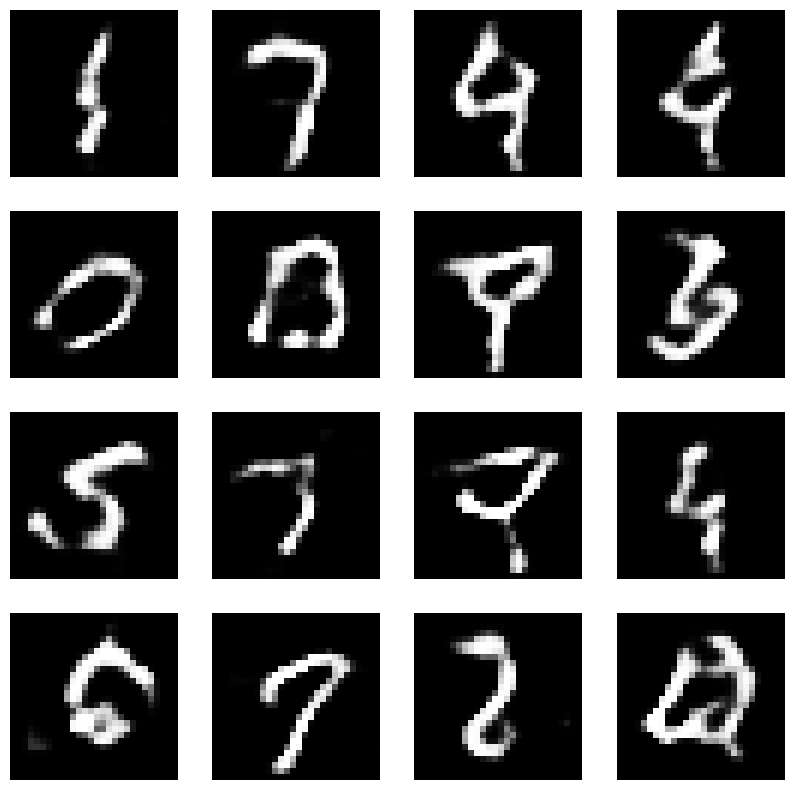

Epoch:  86


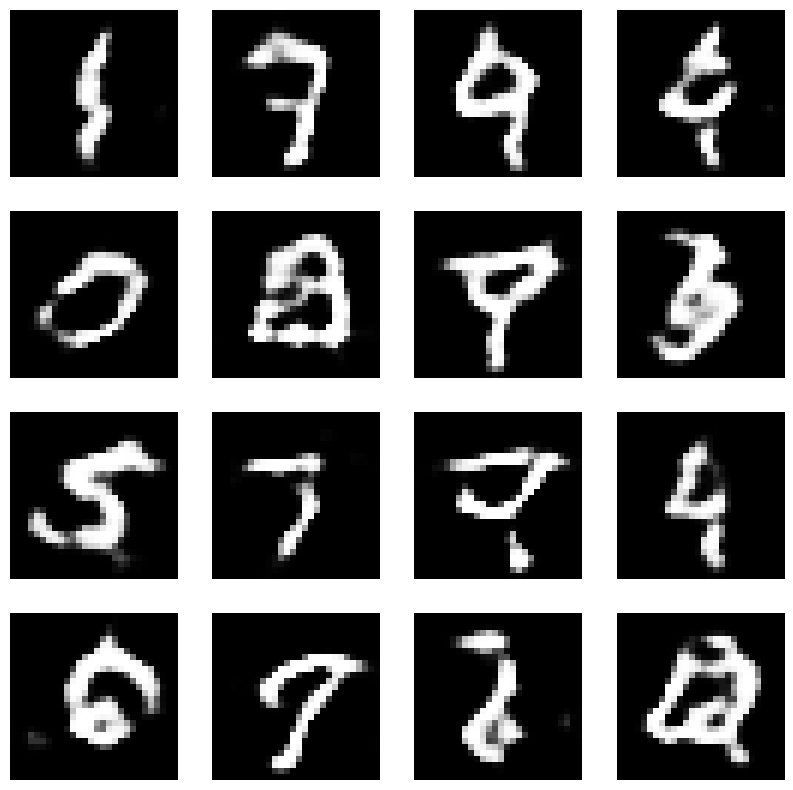

Epoch:  87


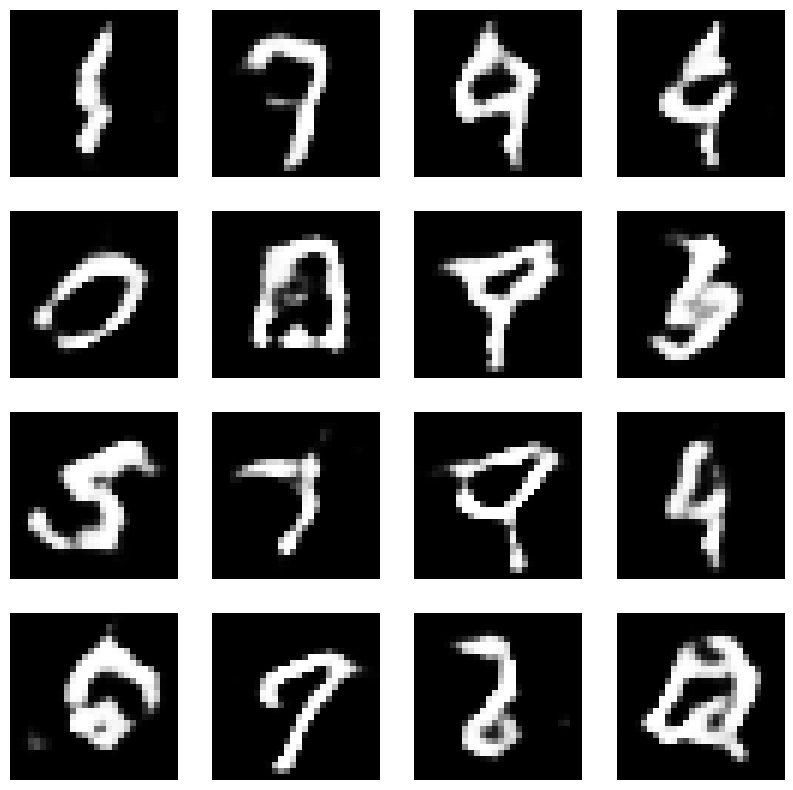

Epoch:  88


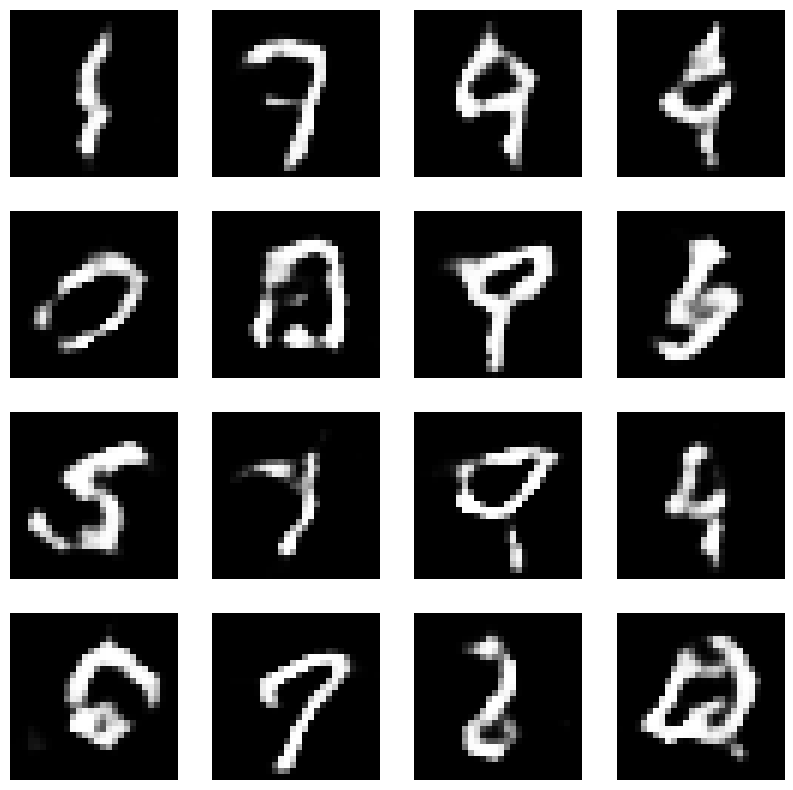

Epoch:  89


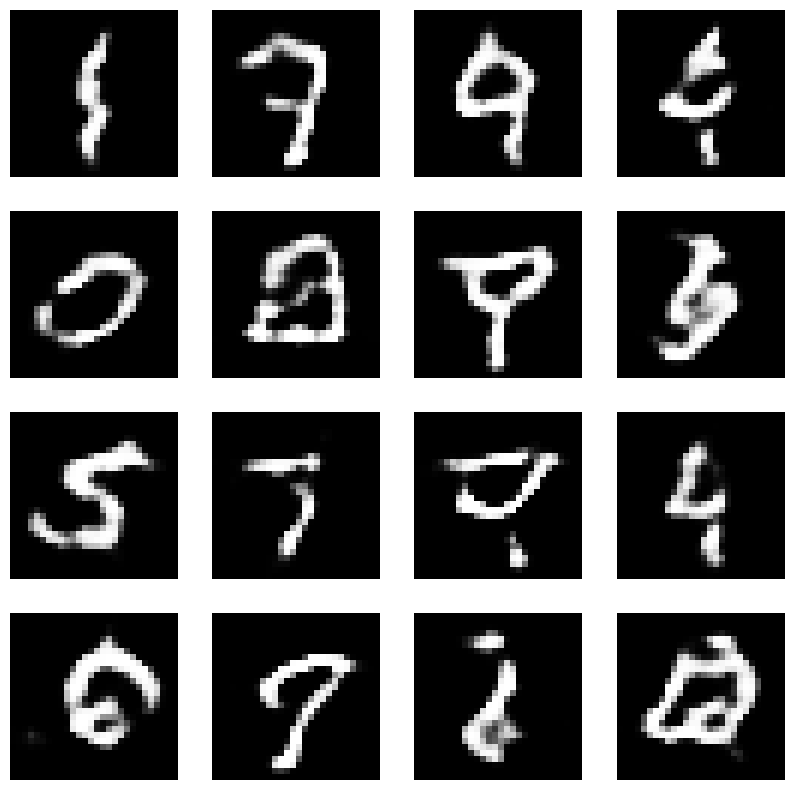

Epoch:  90


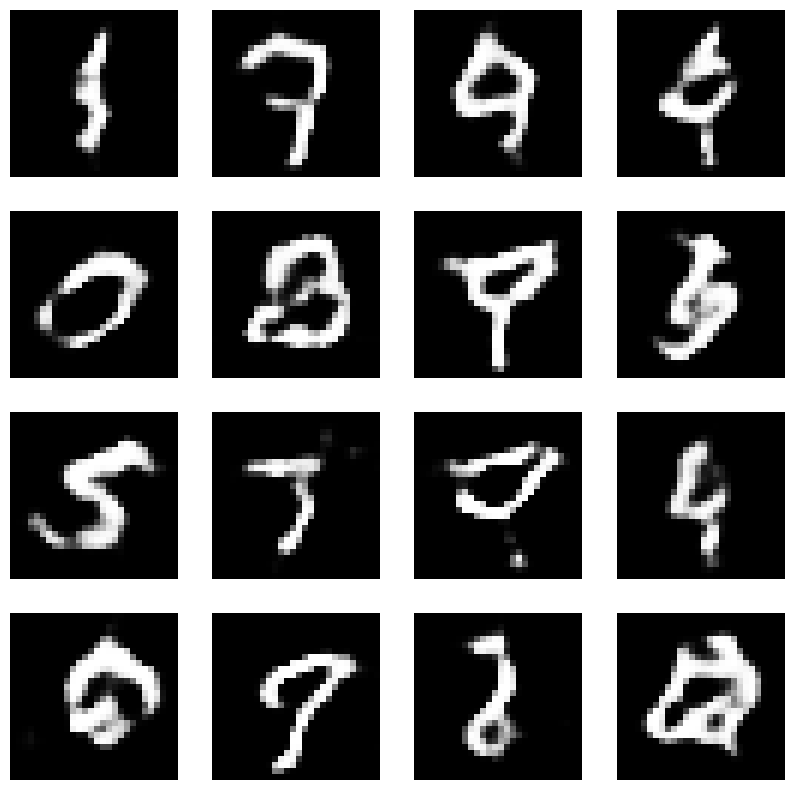

Epoch:  91


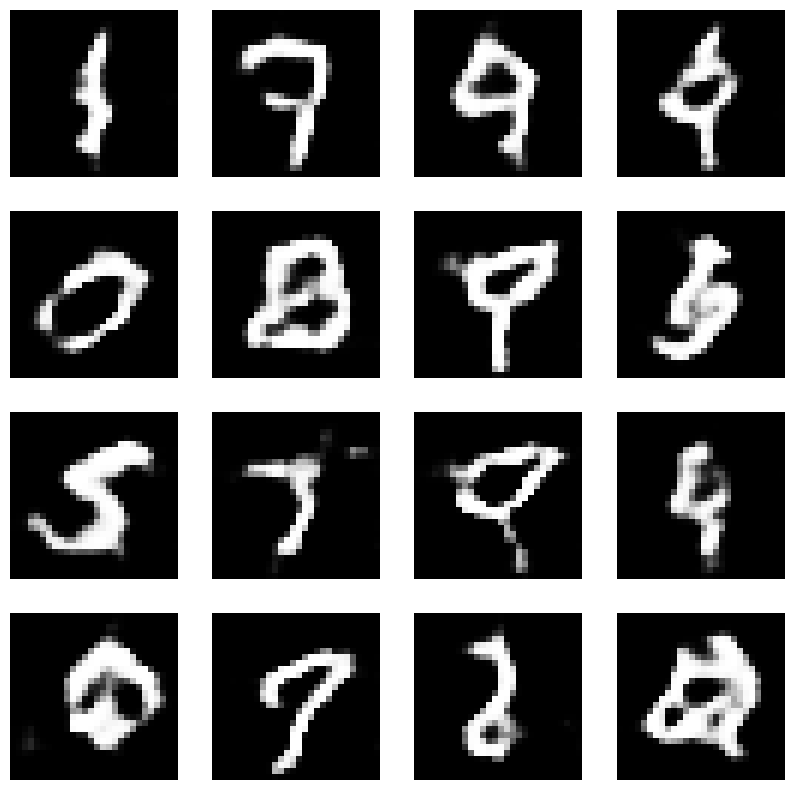

Epoch:  92


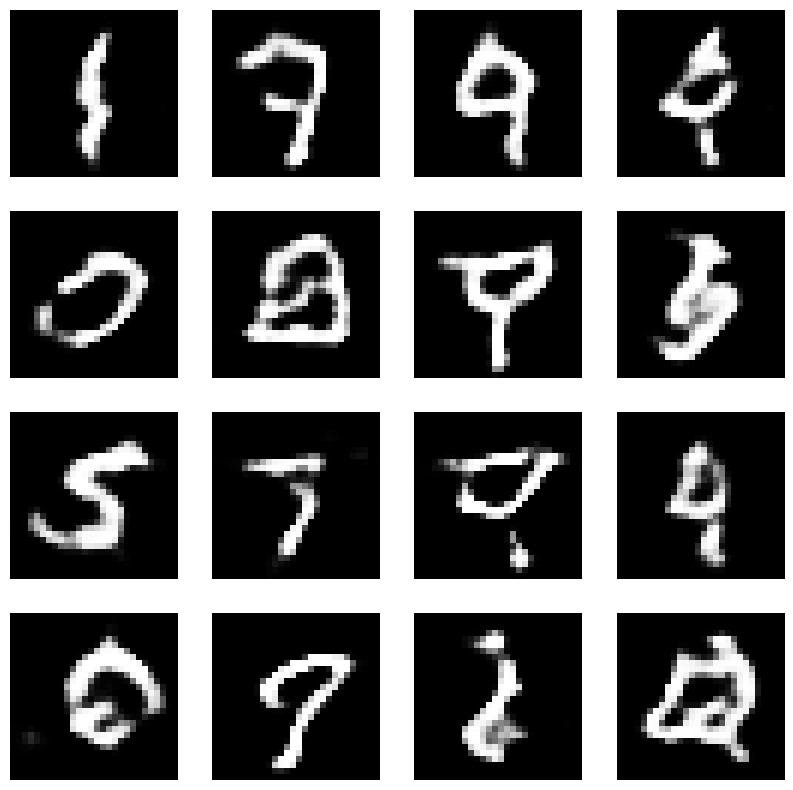

Epoch:  93


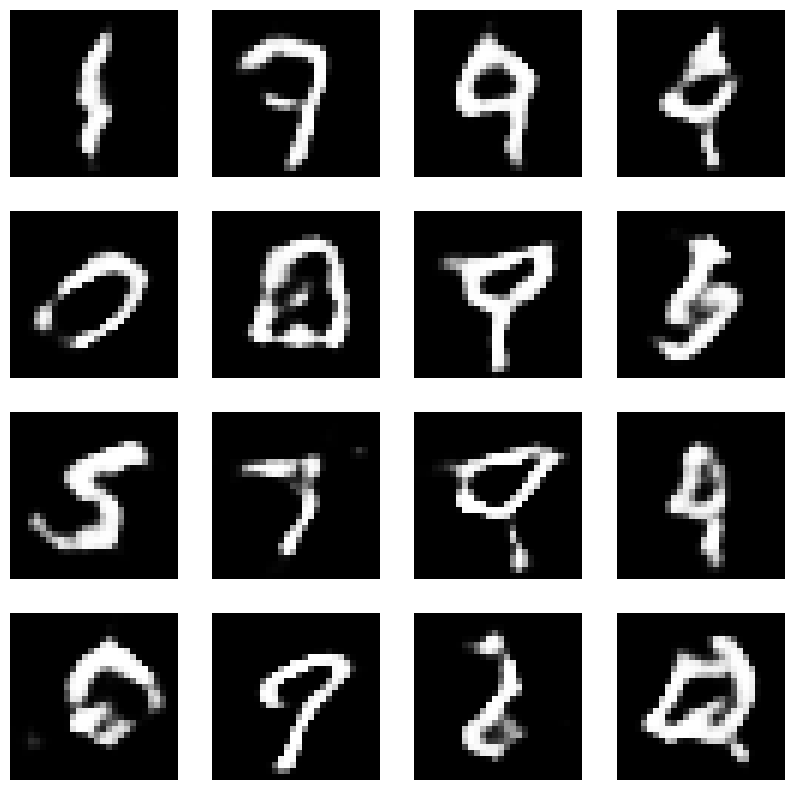

Epoch:  94


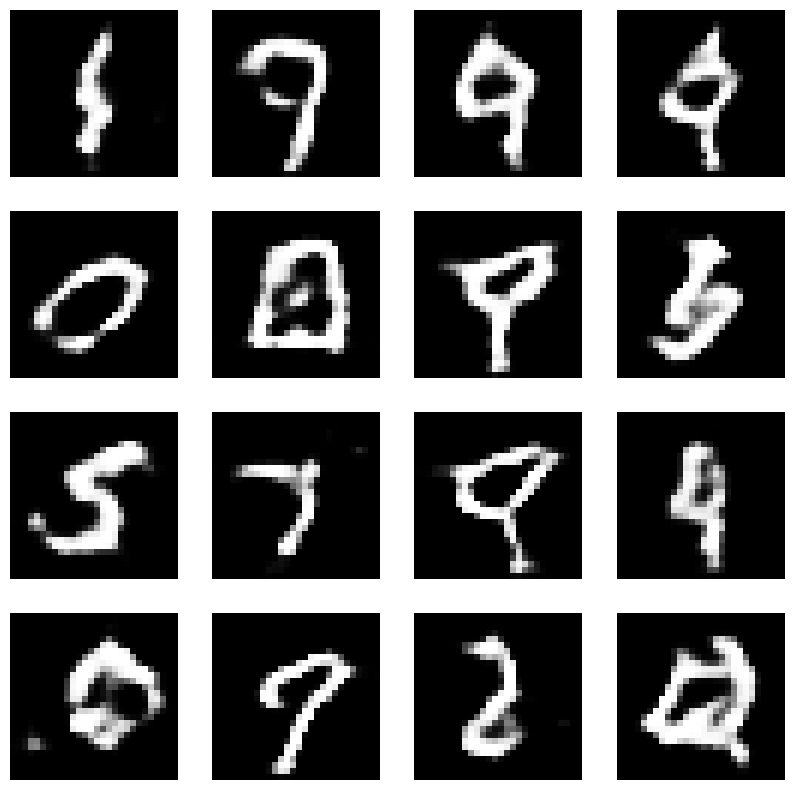

Epoch:  95


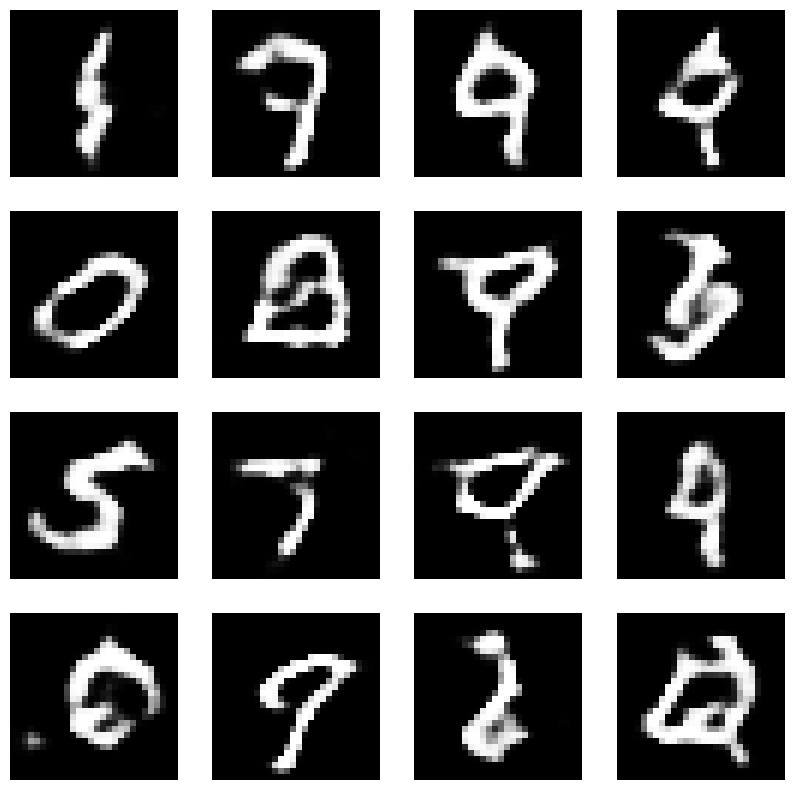

Epoch:  96


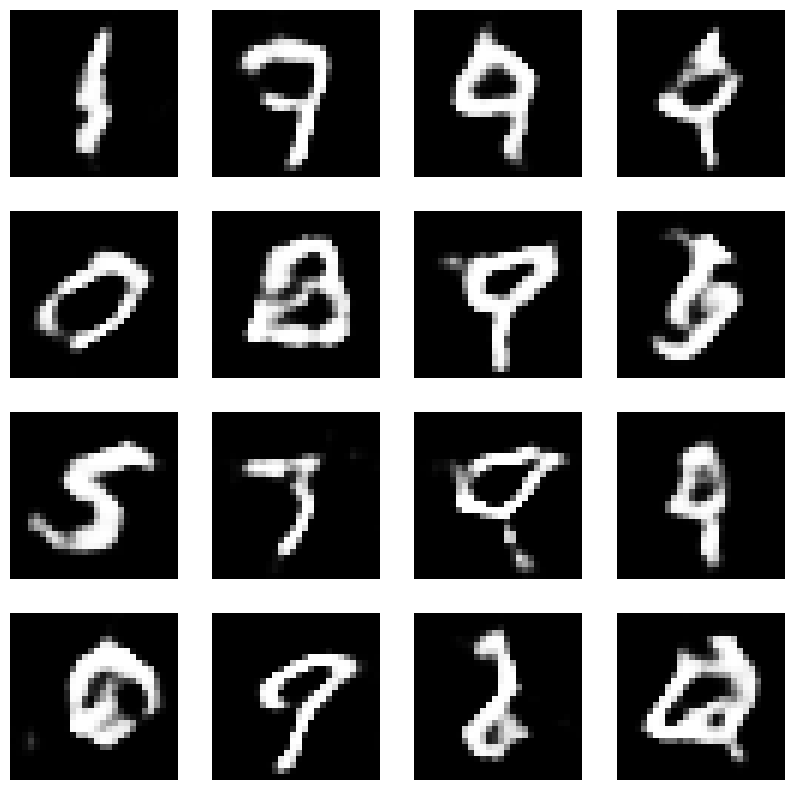

Epoch:  97


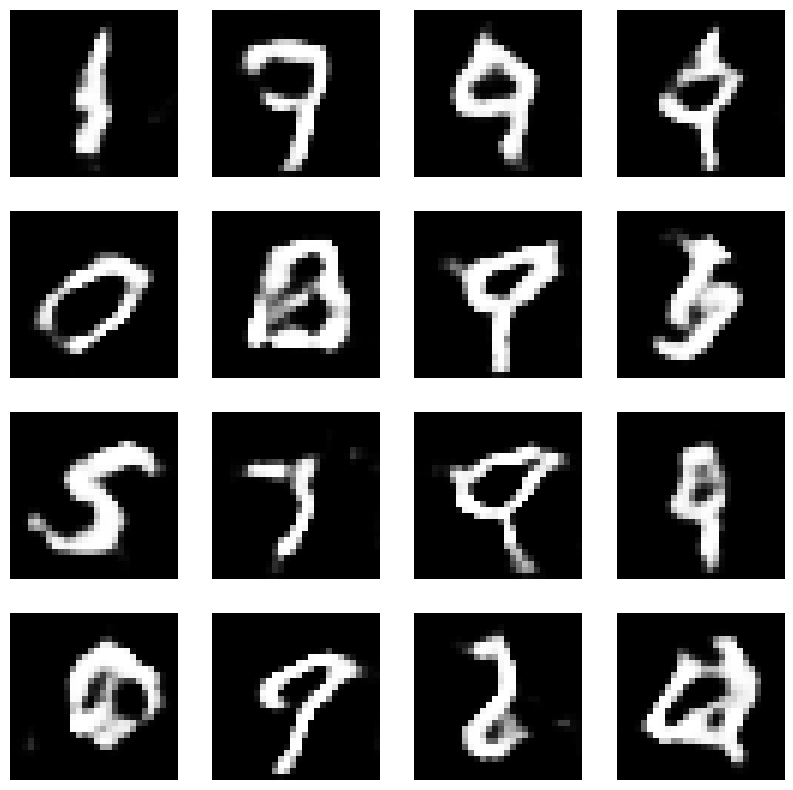

Epoch:  98


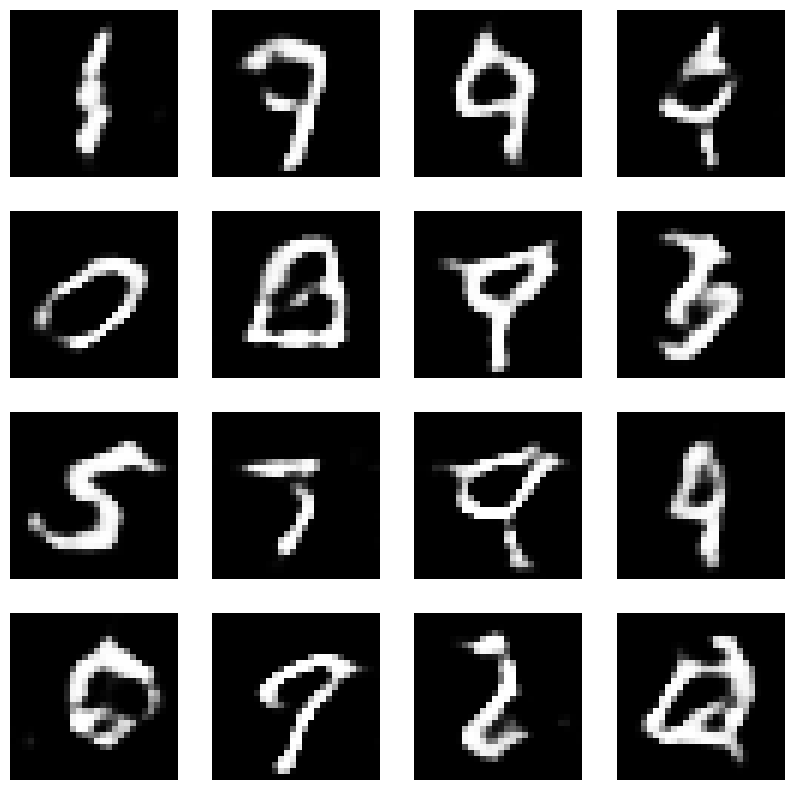

Epoch:  99


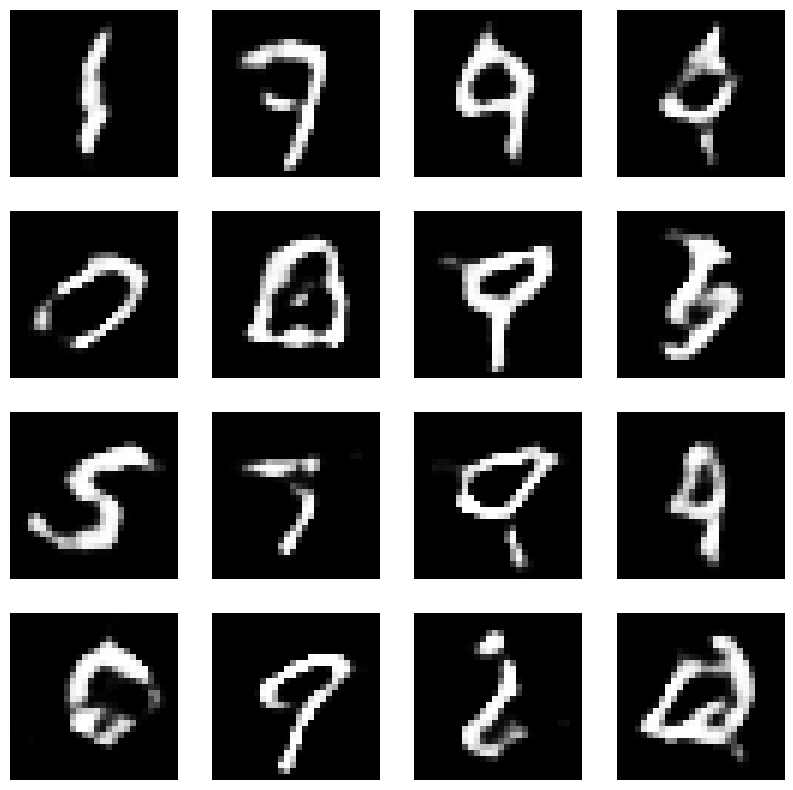

Epoch:  100


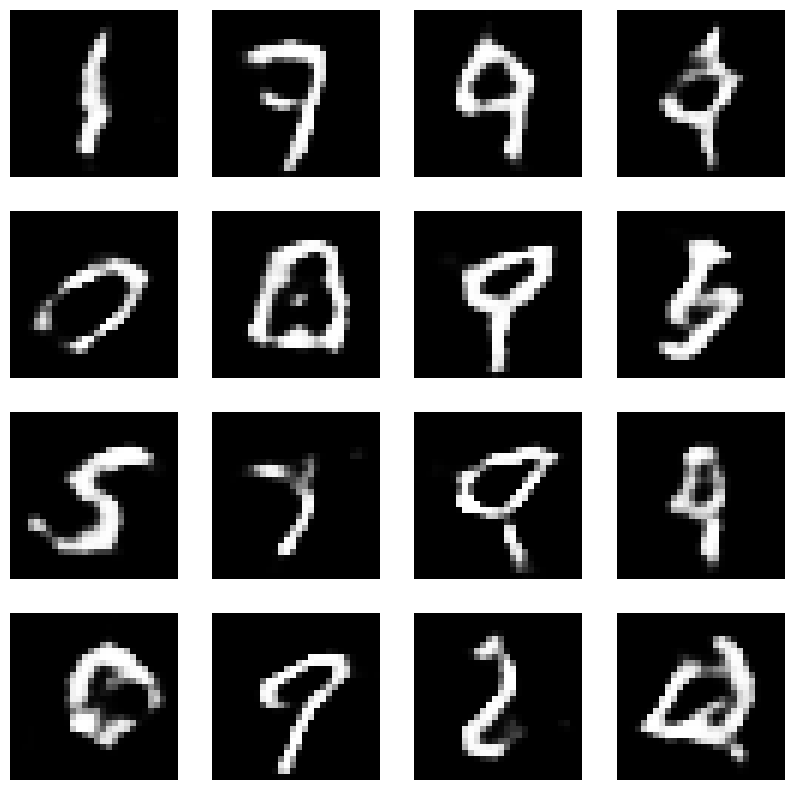

In [39]:
train_gan(X_train,epochs,test_images)
+